# GDELT Conflict Prediction Dataset - Exploratory Data Analysis

## Overview
This notebook performs a comprehensive exploratory data analysis (EDA) on the Global Database of Events, Language, and Tone (GDELT) dataset for conflict prediction modeling. GDELT monitors global news media and provides real-time analysis of events, emotions, and geographic locations.

## Dataset Description
- **Source**: GDELT 2.0 Event Database
- **Time Period**: 2015-2025 (10+ years)
- **Scale**: 548+ million events globally
- **Purpose**: Early warning system for conflict prediction
- **Features**: 58 columns including temporal, geographic, and event characteristics

## Analysis Objectives
1. Understand data structure and quality
2. Identify temporal patterns and trends
3. Analyze geographic distribution of events
4. Explore event types and conflict indicators
5. Assess data suitability for machine learning
6. Generate actionable insights for model development

---

## 1. Import Required Libraries
Let's start by importing all necessary libraries for data analysis and visualization.

In [14]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import polars as pl
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# Datetime handling
from datetime import datetime, timedelta
import calendar

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.2.6
Matplotlib version: 3.10.6
Seaborn version: 0.13.2


## 2. Load and Inspect Dataset
We'll load a representative sample from our processed GDELT dataset across multiple years for comprehensive analysis.

In [15]:
# Define data directory
data_dir = Path("../data/processed/gdelt_all_events")

def load_sample_data(sample_size_per_year=10000):
    """Load representative sample data from all years"""
    print("🔄 Loading GDELT sample data...")
    
    if not data_dir.exists():
        print(f"❌ Data directory not found: {data_dir}")
        return None

    parquet_files = list(data_dir.rglob("*.parquet"))
    print(f"📁 Found {len(parquet_files)} Parquet files")
    
    # Group files by year
    years_files = {}
    for file in parquet_files:
        parts = file.parts
        for part in parts:
            if part.isdigit() and len(part) == 4 and 2015 <= int(part) <= 2025:
                year = int(part)
                if year not in years_files:
                    years_files[year] = []
                years_files[year].append(file)
                break

    print(f"📅 Years available: {sorted(years_files.keys())}")
    
    # Load samples from each year
    samples = []
    for year in sorted(years_files.keys())[:10]:  # 2015-2024
        if year in years_files and years_files[year]:
            year_files = years_files[year][:5]  # Up to 5 files per year
            year_events = []
            
            for file in year_files:
                try:
                    df_file = pl.read_parquet(file)
                    if len(df_file) > 0:
                        sample_size = min(2000, len(df_file))
                        file_sample = df_file.sample(n=sample_size) if len(df_file) > sample_size else df_file
                        year_events.append(file_sample)
                except Exception as e:
                    print(f"⚠️ Could not load {file}: {e}")
                    continue
            
            if year_events:
                year_combined = pl.concat(year_events, how="diagonal_relaxed")
                samples.append(year_combined)
                print(f"   {year}: {len(year_combined):,} events")

    if not samples:
        print("❌ No data could be loaded")
        return None

    # Combine all samples and convert to pandas for traditional EDA
    df_polars = pl.concat(samples, how="diagonal_relaxed")
    df = df_polars.to_pandas()
    
    print(f"\n✅ Successfully loaded {len(df):,} events from {len(samples)} years")
    return df

# Load the data
df = load_sample_data()

# Display basic information
if df is not None:
    print(f"\n📊 Dataset Shape: {df.shape}")
    print(f"🗂️ Columns: {len(df.columns)}")
    print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

🔄 Loading GDELT sample data...
📁 Found 3887 Parquet files
📅 Years available: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
   2015: 10,000 events
   2015: 10,000 events
   2016: 10,000 events
   2016: 10,000 events
   2017: 10,000 events
   2017: 10,000 events
   2018: 10,000 events
   2018: 10,000 events
   2019: 10,000 events
   2020: 2,000 events
   2019: 10,000 events
   2020: 2,000 events
   2021: 10,000 events
   2021: 10,000 events
   2022: 10,000 events
   2022: 10,000 events
   2023: 10,000 events
   2023: 10,000 events
   2024: 10,000 events
   2024: 10,000 events

✅ Successfully loaded 92,000 events from 10 years

📊 Dataset Shape: (92000, 58)
🗂️ Columns: 58
💾 Memory Usage: 141.75 MB

✅ Successfully loaded 92,000 events from 10 years

📊 Dataset Shape: (92000, 58)
🗂️ Columns: 58
💾 Memory Usage: 141.75 MB


In [16]:
# First look at the data
print("🔍 FIRST LOOK AT THE DATA")
print("=" * 50)

if df is not None:
    # Display first few rows
    print("📋 First 5 rows:")
    display(df.head())
    
    print(f"\n📋 Last 5 rows:")
    display(df.tail())
    
    print(f"\n📊 Random sample (5 rows):")
    display(df.sample(5))

🔍 FIRST LOOK AT THE DATA
📋 First 5 rows:


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,330198163,20150101,201501,2015,2015.0027,GOV,KING,None,None,None,None,None,GOV,None,None,None,None,None,None,None,None,None,None,None,None,1,42,42,4,1,1.9,7,2,7,2.793500,3,"Washington, District of Columbia, United States",US,USDC,38.89510,-77.0364,531871,0,None,None,None,NaN,NaN,None,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,20150101,http://www.cbsnews.com/news/selma-critics-ques...
1,330201283,20150101,201501,2015,2015.0027,GOV,GOVERNMENT,None,None,None,None,None,GOV,None,None,MYS,KELANTAN,MYS,None,None,None,None,None,None,None,0,20,20,2,1,3.0,4,1,4,1.589825,4,"Kuala Krai, Kelantan, Malaysia",MY,MY03,5.53130,102.1990,-2402593,4,"Kuala Krai, Kelantan, Malaysia",MY,MY03,5.5313,102.199,-2402593,4,"Kuala Krai, Kelantan, Malaysia",MY,MY03,5.5313,102.1990,-2402593,20150101,http://www.themalaysianinsider.com/sideviews/a...
2,330223505,20150101,201501,2015,2015.0027,NGOCHRHRI,AMERICAN FRIENDS SERVICE COMMITTEE,None,None,None,CHR,None,NGO,HRI,None,None,None,None,None,None,None,None,None,None,None,1,36,36,3,1,4.0,2,1,2,2.824859,1,South Africa,SF,SF,-29.00000,24.0000,SF,0,None,None,None,NaN,NaN,None,1,South Africa,SF,SF,-29.0000,24.0000,SF,20150101,http://www.statesmanjournal.com/story/life/201...
3,330199453,20150101,201501,2015,2015.0027,GOV,FINANCIAL SECRETARY,None,None,None,None,None,GOV,None,None,BUS,BUSINESS,None,None,None,None,None,BUS,None,None,1,36,36,3,1,4.0,3,1,3,1.729107,1,United Kingdom,UK,UK,54.00000,-2.0000,UK,1,United Kingdom,UK,UK,54.0000,-2.000,UK,1,United Kingdom,UK,UK,54.0000,-2.0000,UK,20150101,http://www.telegraph.co.uk/finance/newsbysecto...
4,330222729,20150101,201501,2015,2015.0027,NGA,NIGERIA,NGA,None,None,None,None,None,None,None,DEU,GERMANY,DEU,None,None,None,None,None,None,None,1,181,181,18,4,-9.0,2,1,2,1.509434,4,"Niger Delta, Nigeria (general), Nigeria",NI,NI00,4.83333,6.0000,-2020890,1,Germany,GM,GM,51.0000,9.000,GM,1,Belgium,BE,BE,50.8333,4.0000,BE,20150101,http://dailytimes.com.ng/article/navy-rescues-...



📋 Last 5 rows:


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
91995,1149957702,20240105,202401,2024,2024.0137,USA,DETROIT,USA,None,None,None,None,None,None,None,EDU,SCHOOLHOUSE,None,None,None,None,None,EDU,None,None,1,42,42,4,1,1.9,5,1,5,2.178649,2,"Wisconsin, United States",US,USWI,44.256300,-89.6385,WI,2,"Wisconsin, United States",US,USWI,44.256300,-89.6385,WI,2,"Wisconsin, United States",US,USWI,44.256300,-89.6385,WI,20240105,https://chisagocountypress.com/news/2024/jan/0...
91996,1149898434,20240105,202401,2024,2024.0137,HLH,DOCTOR,None,None,None,None,None,HLH,None,None,None,None,None,None,None,None,None,None,None,None,0,40,40,4,1,1.0,10,1,10,-0.779423,1,United States,US,US,39.828175,-98.5795,US,0,None,None,None,NaN,NaN,None,1,United States,US,US,39.828175,-98.5795,US,20240105,https://www.brushnewstribune.com/2023/12/22/pe...
91997,1149845303,20240105,202401,2024,2024.0137,NGA,NIGERIA,NGA,None,None,None,None,None,None,None,UAF,TERRORIST,None,None,None,None,None,UAF,None,None,1,154,154,15,4,-7.2,4,1,4,-7.052897,5,"Taraba State, Taraba, Nigeria",NI,NI43,8.000000,10.5000,9153503,5,"Taraba State, Taraba, Nigeria",NI,NI43,8.000000,10.5000,9153503,5,"Taraba State, Taraba, Nigeria",NI,NI43,8.000000,10.5000,9153503,20240105,https://www.worthynews.com/92146-nigeria-lawma...
91998,1149954906,20240105,202401,2024,2024.0137,FRA,FRANCE,FRA,None,None,None,None,None,None,None,MOSSUN,SUNNI,None,None,None,MOS,SUN,None,None,None,1,10,10,1,1,0.0,10,1,10,-7.284768,1,Iran,IR,IR,32.000000,53.0000,IR,1,Iran,IR,IR,32.000000,53.0000,IR,1,Iran,IR,IR,32.000000,53.0000,IR,20240105,https://www.france24.com/en/middle-east/202401...
91999,1149883395,20240105,202401,2024,2024.0137,None,None,None,None,None,None,None,None,None,None,THA,THAILAND,THA,None,None,None,None,None,None,None,1,42,42,4,1,1.9,3,1,3,-0.416667,0,None,None,None,NaN,NaN,None,1,United States,US,US,39.828175,-98.5795,US,1,United States,US,US,39.828175,-98.5795,US,20240105,https://finance.yahoo.com/news/chinese-ev-make...



📊 Random sample (5 rows):


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
65883,1021533373,20220102,202201,2022,2022.0055,NZL,WELLINGTON,NZL,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,60,60,6,2,6.0,20,1,20,2.985075,4,"Wellington, New Zealand (general), New Zealand",NZ,NZ00,-41.3000,174.7830,-1521348,0,None,None,None,NaN,NaN,None,4,"Wellington, New Zealand (general), New Zealand",NZ,NZ00,-41.3000,174.7830,-1521348,20220102,https://menafn.com/1103474598/GEMS-Wellington-...
43008,813694650,20190102,201901,2019,2019.0055,RWA,RWANDA,RWA,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,20,20,2,1,3.0,20,2,20,-10.395608,1,Rwanda,RW,RW,-2.0000,30.0000,RW,0,None,None,None,NaN,NaN,None,1,Rwanda,RW,RW,-2.0000,30.0000,RW,20190102,https://news.yahoo.com/15-000-murders-day-augu...
9298,330640324,20150105,201501,2015,2015.0137,TUN,TUNISIA,TUN,None,None,None,None,None,None,None,MAR,MOROCCO,MAR,None,None,None,None,None,None,None,1,36,36,3,1,4.0,2,1,2,0.588235,1,Tunisia,TS,TS,34.0000,9.0000,TS,1,Algeria,AG,AG,28.0000,3.0000,AG,1,Tunisia,TS,TS,34.0000,9.0000,TS,20150105,http://www.moroccoworldnews.com/2015/01/148871...
24256,613679898,20170103,201701,2017,2017.0082,JPN,JAPAN,JPN,None,None,None,None,None,None,None,GBR,BRITAIN,GBR,None,None,None,None,None,None,None,1,50,50,5,1,3.5,3,1,3,4.301075,1,Japan,JA,JA,36.0000,138.0000,JA,4,"Peeblesshire, Scottish Borders, The, United Ki...",UK,UKT9,55.7500,-3.2500,-2605115,4,"Peeblesshire, Scottish Borders, The, United Ki...",UK,UKT9,55.7500,-3.2500,-2605115,20170103,http://www.peeblesshirenews.com/news/14998302....
12802,498839558,20160102,201601,2016,2016.0055,COP,POLICE,None,None,None,None,None,COP,None,None,PSEBUS,PALESTINE,PSE,None,None,None,None,BUS,None,None,0,90,90,9,2,-2.0,10,1,10,-3.838951,4,"Gaza City, Israel (general), Israel",IS,IS00,31.4167,34.3333,-797156,4,"Gaza City, Israel (general), Israel",IS,IS00,31.4167,34.3333,-797156,4,"Gaza City, Israel (general), Israel",IS,IS00,31.4167,34.3333,-797156,20160102,http://pchrgaza.org/en/?p=2144


## 3. Data Overview and Info
Let's examine the dataset structure, data types, and generate basic statistics.

In [17]:
# Dataset Information
print("📊 DATASET INFORMATION")
print("=" * 50)

if df is not None:
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
    print(f"Total cells: {df.shape[0] * df.shape[1]:,}")
    
    print(f"\n🗂️ COLUMN INFORMATION:")
    df.info()
    
    print(f"\n📈 DATA TYPES SUMMARY:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    # Key columns for analysis
    key_columns = ['SQLDATE', 'EventRootCode', 'GoldsteinScale', 'Actor1CountryCode', 
                   'Actor2CountryCode', 'ActionGeo_CountryCode', 'ActionGeo_Lat', 'ActionGeo_Long']
    
    print(f"\n🔑 KEY COLUMNS PRESENT:")
    for col in key_columns:
        status = "✅" if col in df.columns else "❌"
        print(f"   {status} {col}")
    
    # Date range analysis
    if 'SQLDATE' in df.columns:
        df['date'] = pd.to_datetime(df['SQLDATE'], format='%Y%m%d', errors='coerce')
        min_date = df['date'].min()
        max_date = df['date'].max()
        date_span = (max_date - min_date).days
        
        print(f"\n📅 TEMPORAL COVERAGE:")
        print(f"   Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
        print(f"   Span: {date_span} days ({date_span/365.25:.1f} years)")
        print(f"   Years: {sorted(df['date'].dt.year.unique())}")

📊 DATASET INFORMATION
Shape: (92000, 58)
Columns: 58
Total cells: 5,336,000

🗂️ COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92000 entries, 0 to 91999
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GLOBALEVENTID          92000 non-null  int64  
 1   SQLDATE                92000 non-null  int64  
 2   MonthYear              92000 non-null  int64  
 3   Year                   92000 non-null  int64  
 4   FractionDate           92000 non-null  float64
 5   Actor1Code             83027 non-null  object 
 6   Actor1Name             83027 non-null  object 
 7   Actor1CountryCode      50868 non-null  object 
 8   Actor1KnownGroupCode   961 non-null    object 
 9   Actor1EthnicCode       556 non-null    object 
 10  Actor1Religion1Code    1669 non-null   object 
 11  Actor1Religion2Code    459 non-null    object 
 12  Actor1Type1Code        39889 non-null  object 
 13  Actor1

In [18]:
# Statistical Summary
print("📊 STATISTICAL SUMMARY")
print("=" * 50)

if df is not None:
    # Numerical columns summary
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\n🔢 NUMERICAL COLUMNS ({len(numerical_cols)}):")
    if len(numerical_cols) > 0:
        display(df[numerical_cols].describe())

📊 STATISTICAL SUMMARY

🔢 NUMERICAL COLUMNS (25):


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Type,Actor2Geo_Lat,Actor2Geo_Long,ActionGeo_Type,ActionGeo_Lat,ActionGeo_Long,DATEADDED
count,9.200000e+04,9.200000e+04,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.00000,92000.000000,92000.000000,91998.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,80693.000000,80700.000000,92000.000000,63357.000000,63361.000000,92000.000000,89370.000000,89377.000000,9.200000e+04
mean,8.008980e+08,2.019467e+07,201946.652174,2019.456522,2019.464851,0.613554,102.963587,73.11375,7.125272,1.866957,0.267106,13.987359,2.582272,13.654576,-1.831873,2.514663,31.110740,-3.147670,1.969576,31.206451,-0.675833,2.799359,31.054205,-4.105869,2.019467e+07
std,2.616081e+08,2.990629e+04,299.062853,2.990629,2.990655,0.486937,195.127574,57.37345,5.747782,1.160945,4.851082,82.252156,10.190484,77.889986,3.986125,1.510192,19.355126,78.240392,1.695527,19.069534,77.201812,1.323316,19.390477,78.621879,2.990629e+04
min,3.301660e+08,2.015010e+07,201501.000000,2015.000000,2015.002700,0.000000,10.000000,10.00000,1.000000,1.000000,-10.000000,1.000000,1.000000,1.000000,-31.578947,0.000000,-85.622100,-179.983000,0.000000,-85.622100,-178.983000,0.000000,-85.622100,-179.983000,2.015010e+07
25%,6.135273e+08,2.017010e+07,201701.000000,2017.000000,2017.005500,0.000000,36.000000,36.00000,3.000000,1.000000,-2.000000,2.000000,1.000000,2.000000,-4.485211,1.000000,25.172300,-79.500000,0.000000,25.252200,-77.349700,2.000000,25.083300,-80.166700,2.017010e+07
50%,8.139451e+08,2.019010e+07,201901.000000,2019.000000,2019.008200,1.000000,50.000000,46.00000,4.000000,1.000000,1.000000,5.000000,1.000000,5.000000,-1.623536,3.000000,35.537600,7.030410,2.000000,35.000000,9.766670,3.000000,35.537600,6.000000,2.019010e+07
75%,1.021767e+09,2.022010e+07,202201.000000,2022.000000,2022.011000,1.000000,112.000000,111.00000,11.000000,3.000000,3.400000,10.000000,1.000000,10.000000,1.123596,4.000000,42.058400,51.514800,4.000000,42.004600,51.514800,4.000000,42.023075,51.514800,2.022010e+07
max,1.149998e+09,2.024010e+07,202401.000000,2024.000000,2024.013700,1.000000,1832.000000,203.00000,20.000000,4.000000,10.000000,9520.000000,648.000000,8470.000000,17.427386,5.000000,78.216700,179.950000,5.000000,78.216700,180.000000,5.000000,78.216700,180.000000,2.024010e+07


## 4. Handle Missing Values
Analyze missing value patterns and their impact on the analysis.

🔍 MISSING VALUES ANALYSIS
📊 Columns with missing values: 39


,Column,Missing_Count,Missing_Percentage
Actor2Type3Code,Actor2Type3Code,91975,99.972826
Actor1Type3Code,Actor1Type3Code,91950,99.945652
Actor2Religion2Code,Actor2Religion2Code,91582,99.545652
Actor1Religion2Code,Actor1Religion2Code,91541,99.501087
Actor2EthnicCode,Actor2EthnicCode,91531,99.490217
Actor1EthnicCode,Actor1EthnicCode,91444,99.395652
Actor2KnownGroupCode,Actor2KnownGroupCode,91223,99.155435
Actor1KnownGroupCode,Actor1KnownGroupCode,91039,98.955435
Actor2Religion1Code,Actor2Religion1Code,90551,98.425000
Actor1Religion1Code,Actor1Religion1Code,90331,98.185870


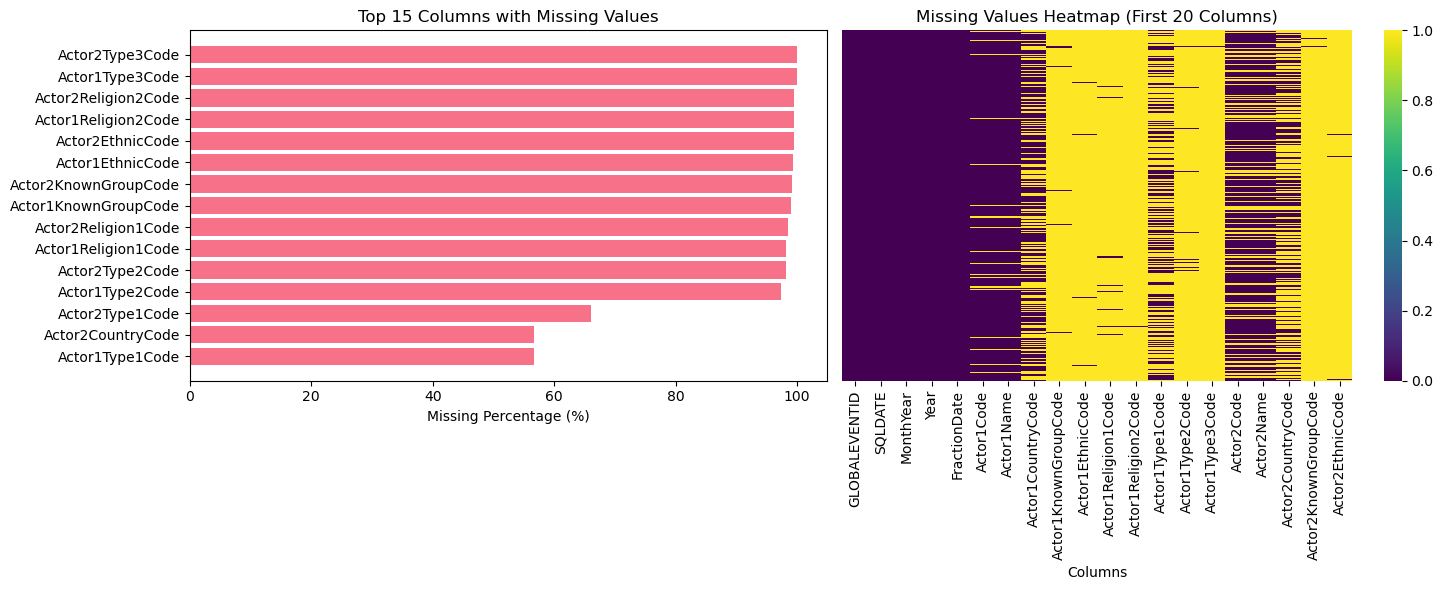


📈 MISSING VALUES SUMMARY:
   Total cells: 5,428,000
   Missing cells: 1,626,018
   Overall completeness: 70.04%

🔑 CRITICAL FIELDS COMPLETENESS:
   🟢 SQLDATE: 100.0% complete
   🟢 EventRootCode: 100.0% complete
   🟢 GoldsteinScale: 100.0% complete
   🟡 Actor1CountryCode: 55.3% complete


In [19]:
# Missing Values Analysis
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 50)

if df is not None:
    # Calculate missing values
    missing_data = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    })
    
    # Filter columns with missing values
    missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
        'Missing_Percentage', ascending=False
    )
    
    print(f"📊 Columns with missing values: {len(missing_data)}")
    if len(missing_data) > 0:
        display(missing_data.head(20))
        
        # Visualize missing values
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Missing values bar chart
        top_missing = missing_data.head(15)
        axes[0].barh(range(len(top_missing)), top_missing['Missing_Percentage'])
        axes[0].set_yticks(range(len(top_missing)))
        axes[0].set_yticklabels(top_missing['Column'])
        axes[0].set_xlabel('Missing Percentage (%)')
        axes[0].set_title('Top 15 Columns with Missing Values')
        axes[0].invert_yaxis()
        
        # Missing values heatmap (sample of columns)
        sample_cols = df.columns[:20] if len(df.columns) > 20 else df.columns
        sns.heatmap(df[sample_cols].isnull(), 
                   yticklabels=False, 
                   cbar=True, 
                   cmap='viridis', 
                   ax=axes[1])
        axes[1].set_title('Missing Values Heatmap (First 20 Columns)')
        axes[1].set_xlabel('Columns')
        
        plt.tight_layout()
        plt.show()
    
    # Missing value summary
    total_cells = df.shape[0] * df.shape[1]
    total_missing = df.isnull().sum().sum()
    overall_completeness = ((total_cells - total_missing) / total_cells) * 100
    
    print(f"\n📈 MISSING VALUES SUMMARY:")
    print(f"   Total cells: {total_cells:,}")
    print(f"   Missing cells: {total_missing:,}")
    print(f"   Overall completeness: {overall_completeness:.2f}%")
    
    # Critical fields analysis
    critical_fields = ['SQLDATE', 'EventRootCode', 'GoldsteinScale', 'Actor1CountryCode']
    print(f"\n🔑 CRITICAL FIELDS COMPLETENESS:")
    for field in critical_fields:
        if field in df.columns:
            missing_pct = (df[field].isnull().sum() / len(df)) * 100
            status = "🟢" if missing_pct < 10 else "🟡" if missing_pct < 50 else "🔴"
            print(f"   {status} {field}: {100 - missing_pct:.1f}% complete")

## 5. Univariate Analysis
Analyze individual variables to understand their distributions and characteristics.

⚔️ EVENT TYPE ANALYSIS (CAMEO CODES)
📊 Top 15 Event Types:
    4: 21,069 ( 22.9%) - Consult
    1: 13,038 ( 14.2%) - Make public statement
    5:  7,550 (  8.2%) - Engage in diplomatic cooperation
   19:  7,177 (  7.8%) - Fight
    2:  6,567 (  7.1%) - Appeal
   11:  6,125 (  6.7%) - Disapprove
    3:  5,907 (  6.4%) - Express intent to cooperate
   17:  4,641 (  5.0%) - Coerce
    8:  3,633 (  3.9%) - Yield
    7:  3,129 (  3.4%) - Provide aid
   12:  2,402 (  2.6%) - Reject
    6:  2,062 (  2.2%) - Engage in material cooperation
    9:  1,955 (  2.1%) - Investigate
   18:  1,696 (  1.8%) - Assault
   13:  1,583 (  1.7%) - Threaten


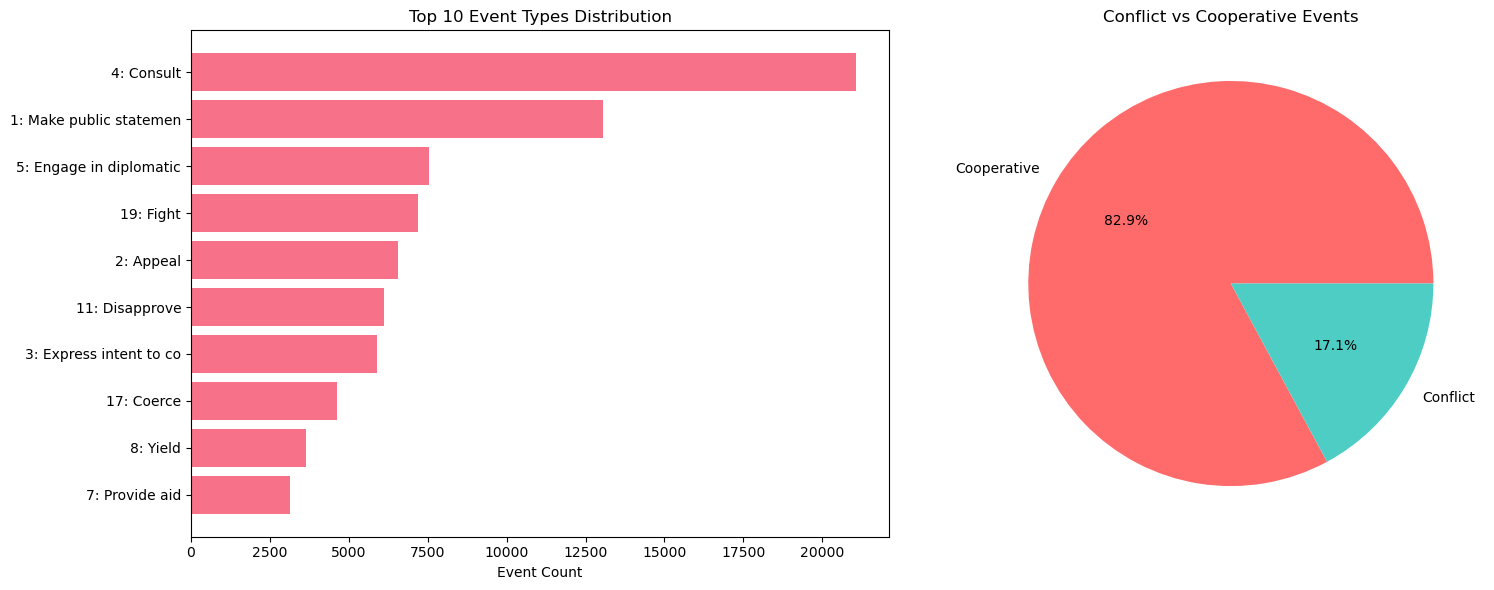


⚔️ CONFLICT ANALYSIS:
   Conflict events: 15,754 (17.1%)
   Cooperative events: 76,246 (82.9%)
   Conflict ratio: 1:4.8

🔥 Most Common Conflict Types:
   19: 7,177 (45.6%) - Fight
   17: 4,641 (29.5%) - Coerce
   18: 1,696 (10.8%) - Assault
   14: 953 (6.0%) - Protest
   16: 924 (5.9%) - Reduce relations

🔥 Most Common Conflict Types:
   19: 7,177 (45.6%) - Fight
   17: 4,641 (29.5%) - Coerce
   18: 1,696 (10.8%) - Assault
   14: 953 (6.0%) - Protest
   16: 924 (5.9%) - Reduce relations


In [20]:
# Event Root Code Analysis (CAMEO Event Types)
print("⚔️ EVENT TYPE ANALYSIS (CAMEO CODES)")
print("=" * 50)

if df is not None and 'EventRootCode' in df.columns:
    # CAMEO code meanings
    cameo_meanings = {
        1: "Make public statement", 2: "Appeal", 3: "Express intent to cooperate",
        4: "Consult", 5: "Engage in diplomatic cooperation", 6: "Engage in material cooperation",
        7: "Provide aid", 8: "Yield", 9: "Investigate", 10: "Demand",
        11: "Disapprove", 12: "Reject", 13: "Threaten", 14: "Protest",
        15: "Exhibit force posture", 16: "Reduce relations", 17: "Coerce",
        18: "Assault", 19: "Fight", 20: "Use unconventional mass violence"
    }
    
    # Event type distribution
    event_counts = df['EventRootCode'].value_counts().head(15)
    print(f"📊 Top 15 Event Types:")
    for code, count in event_counts.items():
        if pd.notna(code):
            percentage = (count / len(df)) * 100
            meaning = cameo_meanings.get(int(code), "Unknown")
            print(f"   {int(code):2d}: {count:6,} ({percentage:5.1f}%) - {meaning}")
    
    # Visualize event type distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    event_counts_top10 = df['EventRootCode'].value_counts().head(10)
    event_labels = [f"{int(code)}: {cameo_meanings.get(int(code), 'Unknown')[:20]}" 
                   for code in event_counts_top10.index if pd.notna(code)]
    
    axes[0].barh(range(len(event_counts_top10)), event_counts_top10.values)
    axes[0].set_yticks(range(len(event_counts_top10)))
    axes[0].set_yticklabels(event_labels)
    axes[0].set_xlabel('Event Count')
    axes[0].set_title('Top 10 Event Types Distribution')
    axes[0].invert_yaxis()
    
    # Conflict vs Cooperative classification
    conflict_codes = [14, 15, 16, 17, 18, 19, 20]  # Protest through Mass Violence
    df['event_category'] = df['EventRootCode'].apply(
        lambda x: 'Conflict' if pd.notna(x) and int(x) in conflict_codes else 'Cooperative'
    )
    
    category_counts = df['event_category'].value_counts()
    axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
               colors=['#ff6b6b', '#4ecdc4'])
    axes[1].set_title('Conflict vs Cooperative Events')
    
    plt.tight_layout()
    plt.show()
    
    # Conflict analysis
    conflict_events = len(df[df['event_category'] == 'Conflict'])
    cooperative_events = len(df[df['event_category'] == 'Cooperative'])
    conflict_percentage = (conflict_events / len(df)) * 100
    
    print(f"\n⚔️ CONFLICT ANALYSIS:")
    print(f"   Conflict events: {conflict_events:,} ({conflict_percentage:.1f}%)")
    print(f"   Cooperative events: {cooperative_events:,} ({100-conflict_percentage:.1f}%)")
    print(f"   Conflict ratio: 1:{cooperative_events/conflict_events:.1f}")
    
    # Most common conflict types
    conflict_df = df[df['event_category'] == 'Conflict']
    if len(conflict_df) > 0:
        conflict_types = conflict_df['EventRootCode'].value_counts()
        print(f"\n🔥 Most Common Conflict Types:")
        for code, count in conflict_types.head(5).items():
            if pd.notna(code):
                meaning = cameo_meanings.get(int(code), "Unknown")
                percentage = (count / len(conflict_df)) * 100
                print(f"   {int(code):2d}: {count:,} ({percentage:.1f}%) - {meaning}")

📊 GOLDSTEIN SCALE ANALYSIS (EVENT INTENSITY)
📈 Goldstein Scale Statistics:
   Count: 91,998
   Mean: 0.267
   Std: 4.851
   Min: -10.0
   Max: 10.0
   Median: 1.000

🌡️ Intensity Categories:
   Positive: 40,016 (43.5%)
   Negative: 23,037 (25.0%)
   Very Negative: 17,260 (18.8%)
   Very Positive: 11,685 (12.7%)


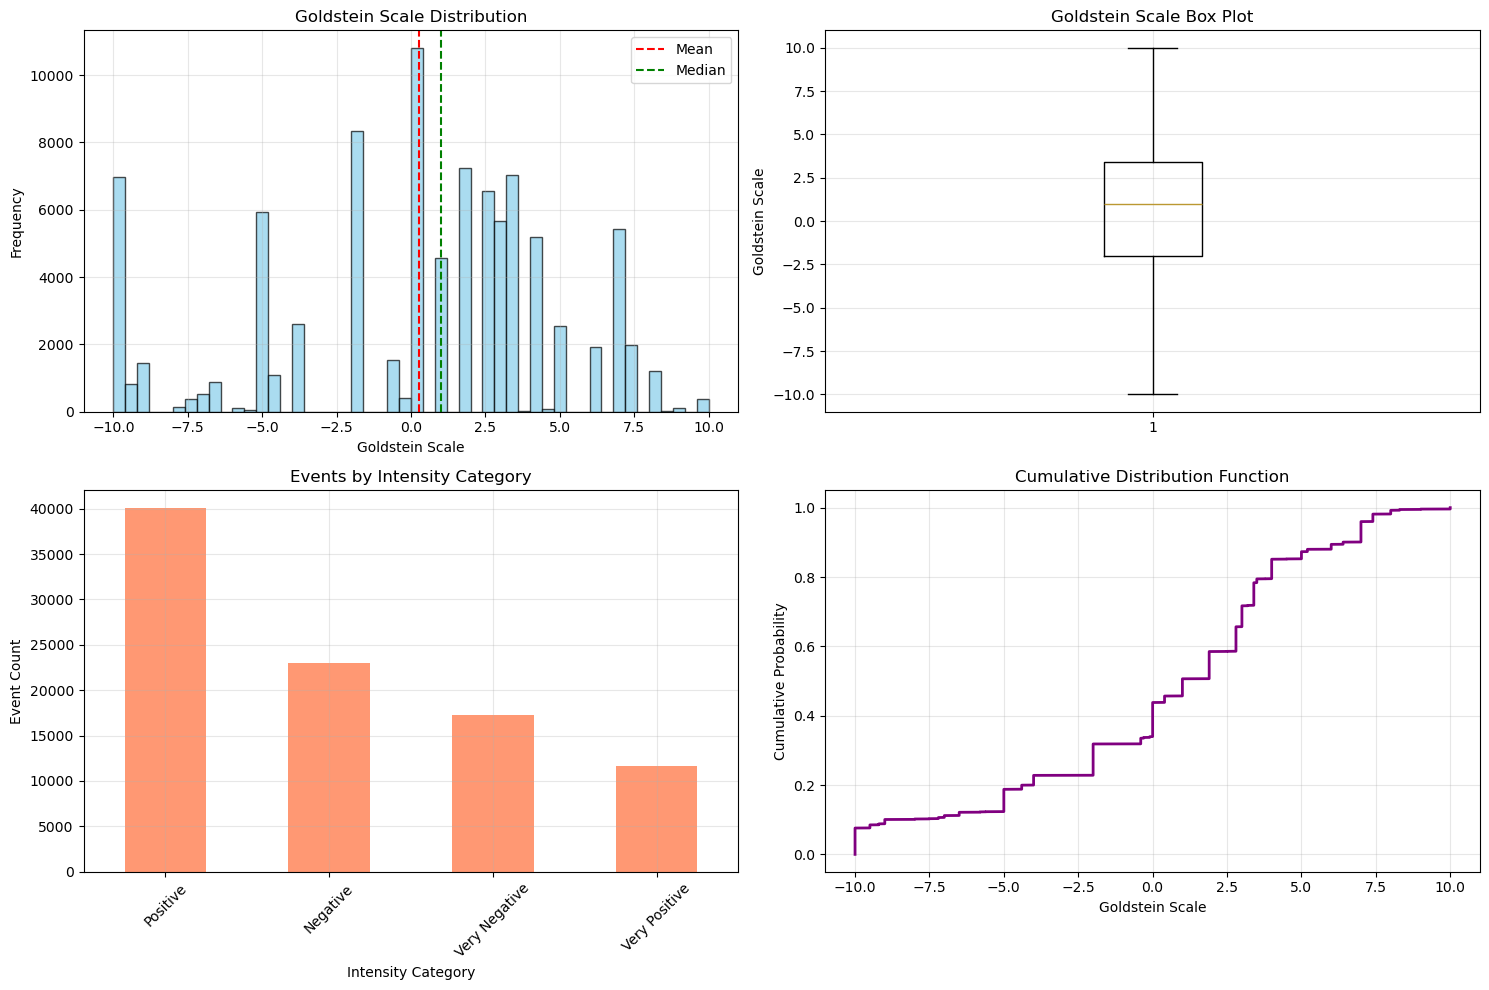


🔥 Extreme Events:
   Extreme negative (<-8): 9,254 events
   Extreme positive (>8): 706 events
   Extreme events ratio: 10.83%


In [21]:
# Goldstein Scale Analysis (Event Intensity)
print("📊 GOLDSTEIN SCALE ANALYSIS (EVENT INTENSITY)")
print("=" * 50)

if df is not None and 'GoldsteinScale' in df.columns:
    # Basic statistics
    gs_stats = df['GoldsteinScale'].describe()
    print(f"📈 Goldstein Scale Statistics:")
    print(f"   Count: {gs_stats['count']:,.0f}")
    print(f"   Mean: {gs_stats['mean']:.3f}")
    print(f"   Std: {gs_stats['std']:.3f}")
    print(f"   Min: {gs_stats['min']:.1f}")
    print(f"   Max: {gs_stats['max']:.1f}")
    print(f"   Median: {gs_stats['50%']:.3f}")
    
    # Intensity categories
    df['intensity_category'] = pd.cut(df['GoldsteinScale'], 
                                     bins=[-np.inf, -5, 0, 5, np.inf],
                                     labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])
    
    intensity_counts = df['intensity_category'].value_counts()
    print(f"\n🌡️ Intensity Categories:")
    for category, count in intensity_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {category}: {count:,} ({percentage:.1f}%)")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram
    axes[0,0].hist(df['GoldsteinScale'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(df['GoldsteinScale'].mean(), color='red', linestyle='--', label='Mean')
    axes[0,0].axvline(df['GoldsteinScale'].median(), color='green', linestyle='--', label='Median')
    axes[0,0].set_xlabel('Goldstein Scale')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Goldstein Scale Distribution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Box plot
    axes[0,1].boxplot(df['GoldsteinScale'].dropna(), vert=True)
    axes[0,1].set_ylabel('Goldstein Scale')
    axes[0,1].set_title('Goldstein Scale Box Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Intensity categories bar chart
    intensity_counts.plot(kind='bar', ax=axes[1,0], color='coral', alpha=0.8)
    axes[1,0].set_xlabel('Intensity Category')
    axes[1,0].set_ylabel('Event Count')
    axes[1,0].set_title('Events by Intensity Category')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Cumulative distribution
    sorted_gs = np.sort(df['GoldsteinScale'].dropna())
    y_vals = np.arange(1, len(sorted_gs) + 1) / len(sorted_gs)
    axes[1,1].plot(sorted_gs, y_vals, color='purple', linewidth=2)
    axes[1,1].set_xlabel('Goldstein Scale')
    axes[1,1].set_ylabel('Cumulative Probability')
    axes[1,1].set_title('Cumulative Distribution Function')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Extreme events analysis
    extreme_negative = df[df['GoldsteinScale'] < -8]
    extreme_positive = df[df['GoldsteinScale'] > 8]
    
    print(f"\n🔥 Extreme Events:")
    print(f"   Extreme negative (<-8): {len(extreme_negative):,} events")
    print(f"   Extreme positive (>8): {len(extreme_positive):,} events")
    print(f"   Extreme events ratio: {(len(extreme_negative) + len(extreme_positive)) / len(df) * 100:.2f}%")

## 6. Bivariate Analysis
Explore relationships between pairs of variables to identify patterns and correlations.

📅 TEMPORAL PATTERNS ANALYSIS


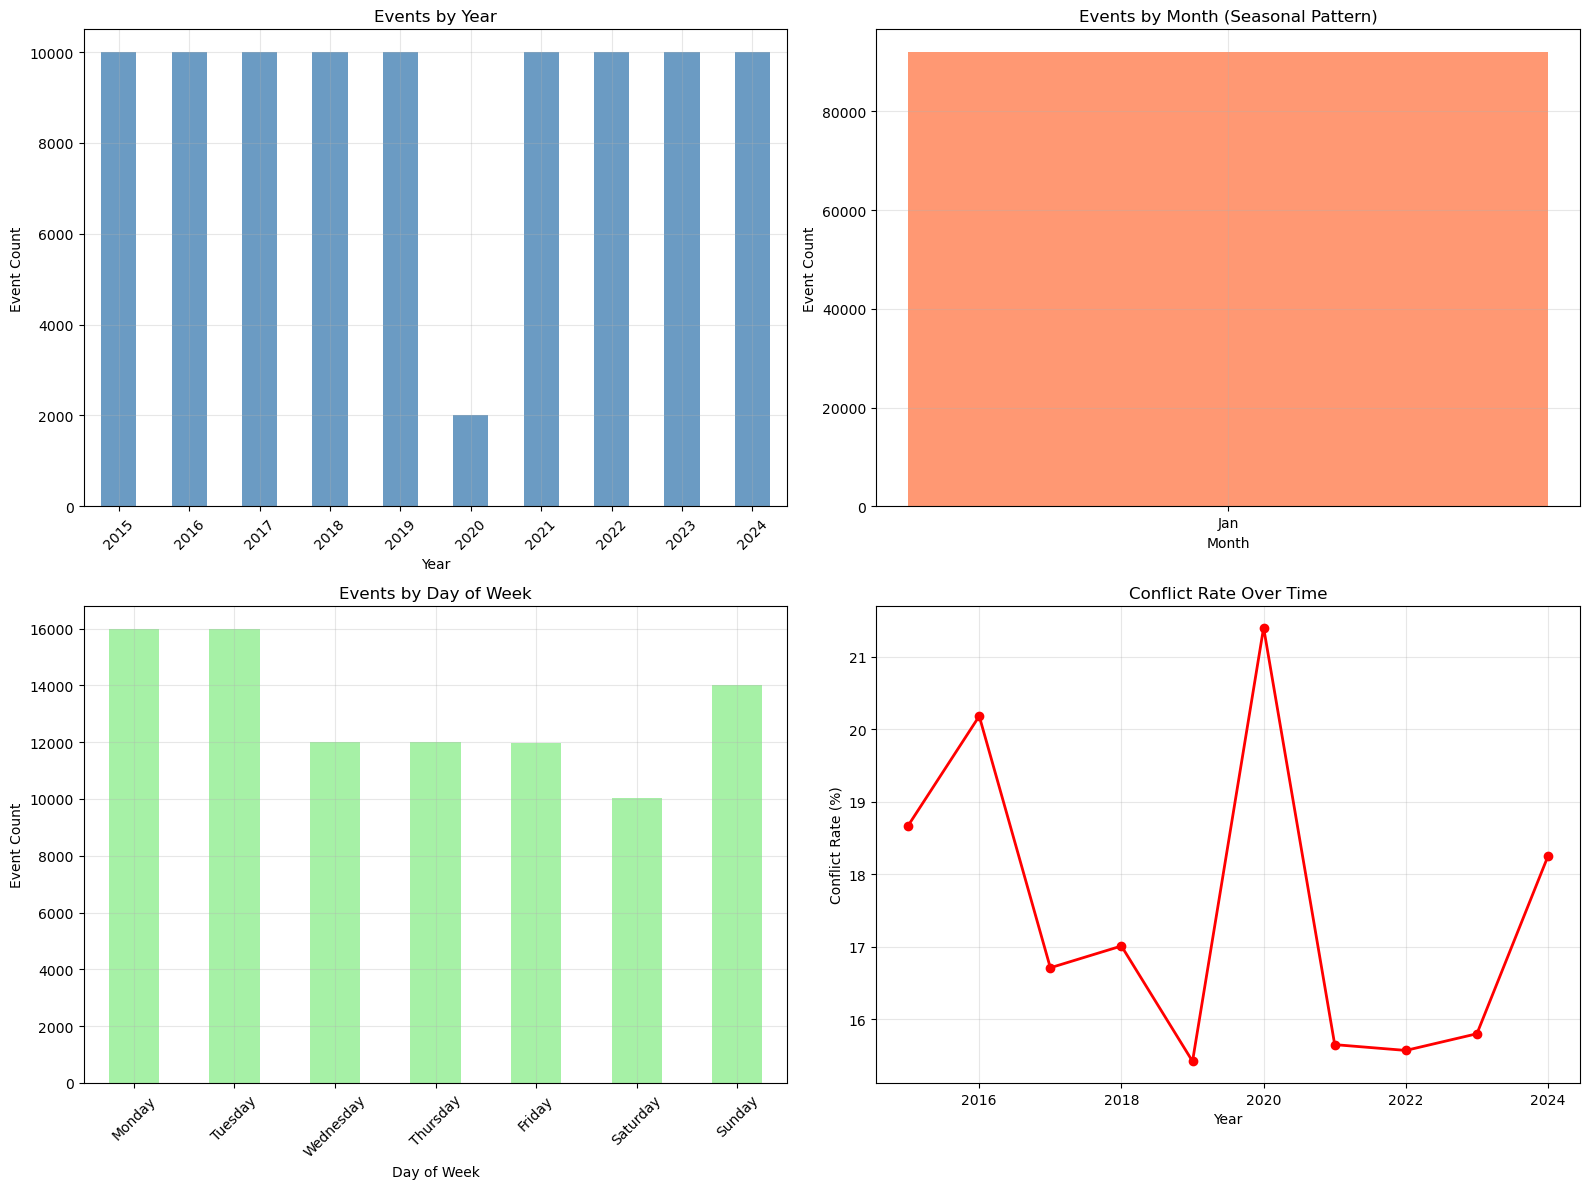


🗓️ SEASONAL PATTERNS:
   Highest activity month: 1 (92,000 events)
   Lowest activity month: 1 (92,000 events)
   Seasonal variation: 0.0%

📅 WEEKLY PATTERNS:
   Highest activity day: Monday (15,994 events)
   Lowest activity day: Saturday (10,022 events)

📈 TEMPORAL TRENDS:
   Years covered: 2015 - 2024
   Total events per year: 9200 ± 2530
   Trend: decreasing (not significant, R² = 0.003)
   Annual change: -48 events/year


In [22]:
# Temporal Patterns Analysis
print("📅 TEMPORAL PATTERNS ANALYSIS")
print("=" * 50)

if df is not None and 'date' in df.columns:
    # Add temporal features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_name'] = df['date'].dt.day_name()
    df['month_name'] = df['date'].dt.month_name()
    
    # Events over time
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Events by year
    yearly_counts = df.groupby('year').size()
    yearly_counts.plot(kind='bar', ax=axes[0,0], color='steelblue', alpha=0.8)
    axes[0,0].set_title('Events by Year')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Event Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Events by month
    monthly_counts = df.groupby('month').size()
    month_labels = [calendar.month_abbr[i] for i in monthly_counts.index]
    axes[0,1].bar(range(len(monthly_counts)), monthly_counts.values, color='coral', alpha=0.8)
    axes[0,1].set_xticks(range(len(monthly_counts)))
    axes[0,1].set_xticklabels(month_labels)
    axes[0,1].set_title('Events by Month (Seasonal Pattern)')
    axes[0,1].set_xlabel('Month')
    axes[0,1].set_ylabel('Event Count')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Events by day of week
    dow_counts = df.groupby('day_name').size()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_counts = dow_counts.reindex(day_order)
    dow_counts.plot(kind='bar', ax=axes[1,0], color='lightgreen', alpha=0.8)
    axes[1,0].set_title('Events by Day of Week')
    axes[1,0].set_xlabel('Day of Week')
    axes[1,0].set_ylabel('Event Count')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Conflict events over time
    if 'event_category' in df.columns:
        conflict_by_year = df[df['event_category'] == 'Conflict'].groupby('year').size()
        total_by_year = df.groupby('year').size()
        conflict_rate = (conflict_by_year / total_by_year * 100).fillna(0)
        
        axes[1,1].plot(conflict_rate.index, conflict_rate.values, marker='o', color='red', linewidth=2)
        axes[1,1].set_title('Conflict Rate Over Time')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Conflict Rate (%)')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Seasonal analysis
    print(f"\n🗓️ SEASONAL PATTERNS:")
    print(f"   Highest activity month: {monthly_counts.idxmax()} ({monthly_counts.max():,} events)")
    print(f"   Lowest activity month: {monthly_counts.idxmin()} ({monthly_counts.min():,} events)")
    print(f"   Seasonal variation: {(monthly_counts.max() - monthly_counts.min()) / monthly_counts.mean() * 100:.1f}%")
    
    print(f"\n📅 WEEKLY PATTERNS:")
    print(f"   Highest activity day: {dow_counts.idxmax()} ({dow_counts.max():,} events)")
    print(f"   Lowest activity day: {dow_counts.idxmin()} ({dow_counts.min():,} events)")
    
    # Trend analysis
    print(f"\n📈 TEMPORAL TRENDS:")
    print(f"   Years covered: {df['year'].min()} - {df['year'].max()}")
    print(f"   Total events per year: {yearly_counts.mean():.0f} ± {yearly_counts.std():.0f}")
    
    if len(yearly_counts) > 1:
        # Calculate trend
        years = yearly_counts.index.values
        counts = yearly_counts.values
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, counts)
        
        trend_direction = "increasing" if slope > 0 else "decreasing"
        trend_significance = "significant" if p_value < 0.05 else "not significant"
        
        print(f"   Trend: {trend_direction} ({trend_significance}, R² = {r_value**2:.3f})")
        print(f"   Annual change: {slope:+.0f} events/year")

🌍 GEOGRAPHIC ANALYSIS
📍 Top Event Initiator Countries:
    1. USA: 16,218 events (17.63%)
    2. GBR: 2,450 events (2.66%)
    3. CHN: 1,575 events (1.71%)
    4. ISR: 1,508 events (1.64%)
    5. RUS: 1,404 events (1.53%)
    6. NGA: 1,193 events (1.30%)
    7. IRN: 1,193 events (1.30%)
    8. PAK: 1,117 events (1.21%)
    9. CAN: 1,116 events (1.21%)
   10. IND: 1,102 events (1.20%)

🗺️ Geographic Coverage:
   Events with coordinates: 89,370 (97.1%)
   Latitude range: -85.6° to 78.2°
   Longitude range: -180.0° to 180.0°

🗺️ Geographic Coverage:
   Events with coordinates: 89,370 (97.1%)
   Latitude range: -85.6° to 78.2°
   Longitude range: -180.0° to 180.0°


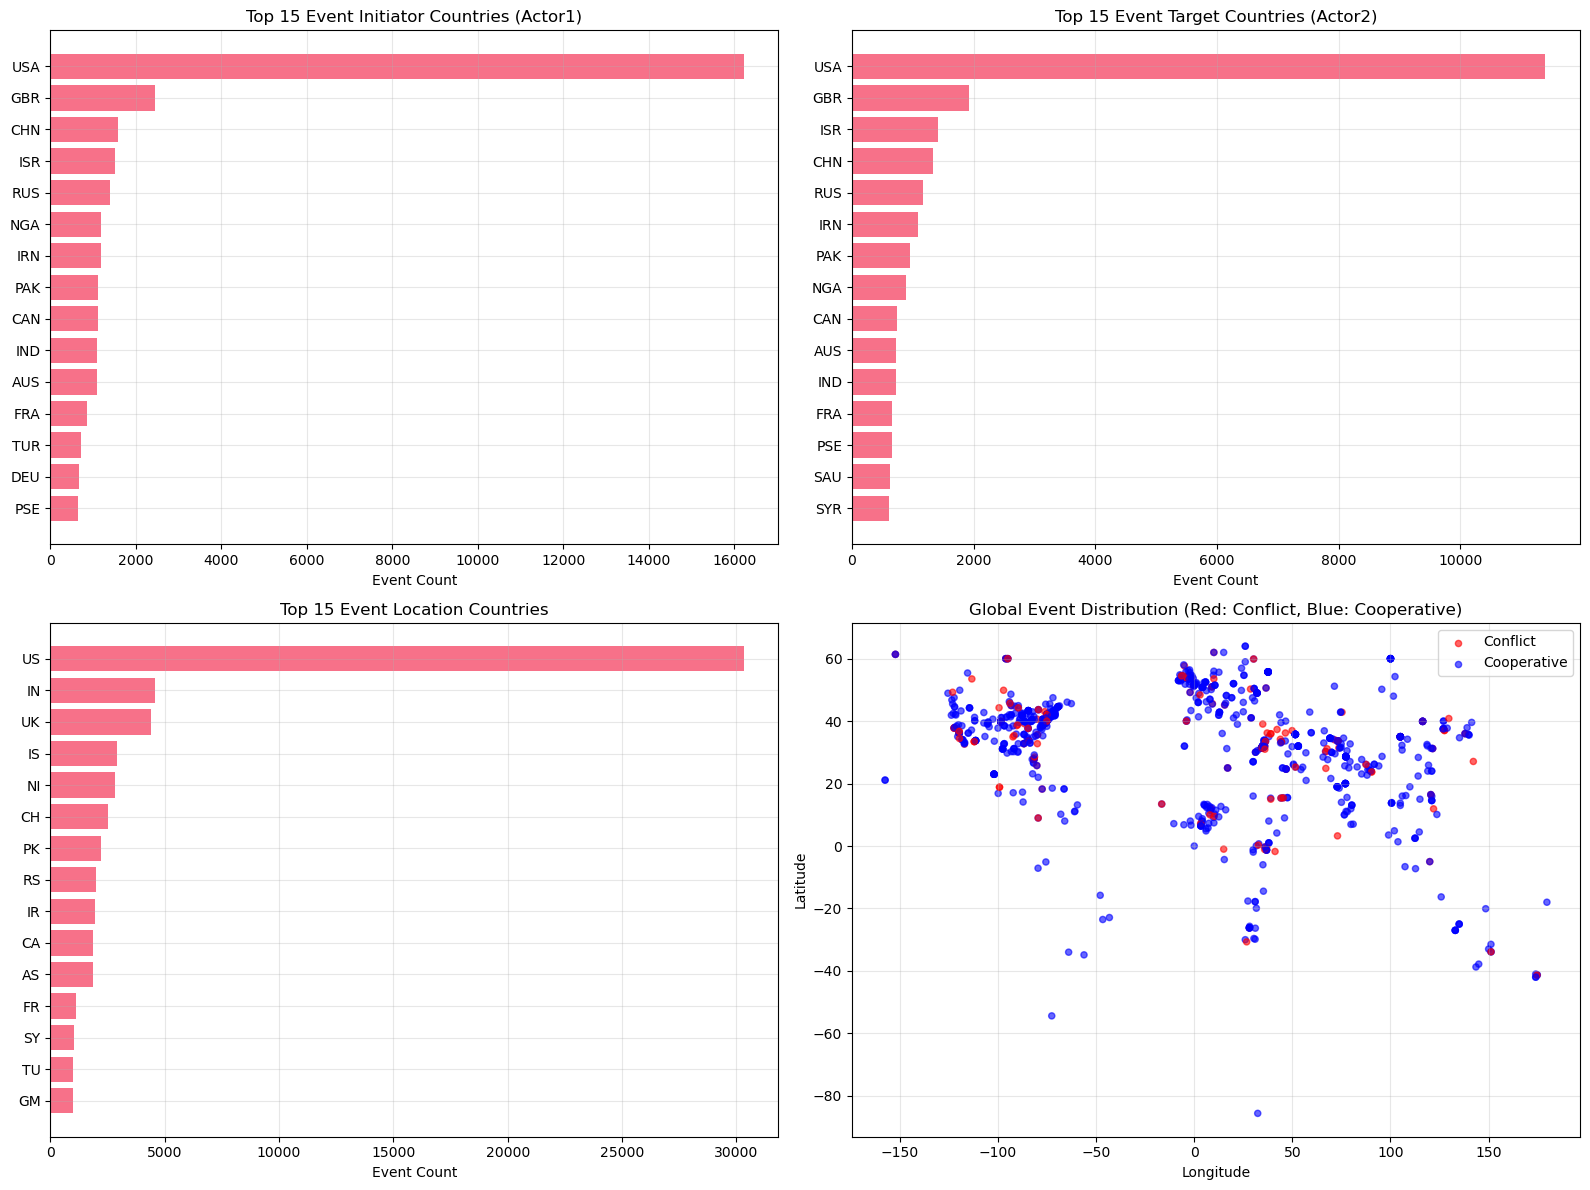


🌐 Regional Distribution:
   Northern Hemisphere: 83,415 events (93.3%)
   Southern Hemisphere: 5,955 events (6.7%)
   Equatorial region (±10°): 7,157 events (8.0%)


In [23]:
# Geographic Analysis
print("🌍 GEOGRAPHIC ANALYSIS")
print("=" * 50)

if df is not None:
    # Country involvement analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top countries (Actor1 - Event initiators)
    if 'Actor1CountryCode' in df.columns:
        actor1_counts = df['Actor1CountryCode'].value_counts().head(15)
        if len(actor1_counts) > 0:
            axes[0,0].barh(range(len(actor1_counts)), actor1_counts.values)
            axes[0,0].set_yticks(range(len(actor1_counts)))
            axes[0,0].set_yticklabels(actor1_counts.index)
            axes[0,0].set_xlabel('Event Count')
            axes[0,0].set_title('Top 15 Event Initiator Countries (Actor1)')
            axes[0,0].invert_yaxis()
            axes[0,0].grid(True, alpha=0.3)
            
            print(f"📍 Top Event Initiator Countries:")
            for i, (country, count) in enumerate(actor1_counts.head(10).items(), 1):
                percentage = (count / len(df)) * 100
                print(f"   {i:2d}. {country}: {count:,} events ({percentage:.2f}%)")
    
    # 2. Top target countries (Actor2)
    if 'Actor2CountryCode' in df.columns:
        actor2_counts = df['Actor2CountryCode'].value_counts().head(15)
        if len(actor2_counts) > 0:
            axes[0,1].barh(range(len(actor2_counts)), actor2_counts.values)
            axes[0,1].set_yticks(range(len(actor2_counts)))
            axes[0,1].set_yticklabels(actor2_counts.index)
            axes[0,1].set_xlabel('Event Count')
            axes[0,1].set_title('Top 15 Event Target Countries (Actor2)')
            axes[0,1].invert_yaxis()
            axes[0,1].grid(True, alpha=0.3)
    
    # 3. Event location countries
    if 'ActionGeo_CountryCode' in df.columns:
        geo_counts = df['ActionGeo_CountryCode'].value_counts().head(15)
        if len(geo_counts) > 0:
            axes[1,0].barh(range(len(geo_counts)), geo_counts.values)
            axes[1,0].set_yticks(range(len(geo_counts)))
            axes[1,0].set_yticklabels(geo_counts.index)
            axes[1,0].set_xlabel('Event Count')
            axes[1,0].set_title('Top 15 Event Location Countries')
            axes[1,0].invert_yaxis()
            axes[1,0].grid(True, alpha=0.3)
    
    # 4. Geographic coordinates scatter plot
    if all(col in df.columns for col in ['ActionGeo_Lat', 'ActionGeo_Long']):
        # Filter valid coordinates
        geo_df = df.dropna(subset=['ActionGeo_Lat', 'ActionGeo_Long'])
        geo_df = geo_df[
            (geo_df['ActionGeo_Lat'] >= -90) & (geo_df['ActionGeo_Lat'] <= 90) &
            (geo_df['ActionGeo_Long'] >= -180) & (geo_df['ActionGeo_Long'] <= 180)
        ]
        
        if len(geo_df) > 0:
            # Sample for performance
            if len(geo_df) > 1000:
                geo_sample = geo_df.sample(n=1000)
            else:
                geo_sample = geo_df
                
            # Color by conflict status if available
            if 'event_category' in geo_sample.columns:
                colors = ['red' if cat == 'Conflict' else 'blue' for cat in geo_sample['event_category']]
                axes[1,1].scatter(geo_sample['ActionGeo_Long'], geo_sample['ActionGeo_Lat'], 
                                c=colors, alpha=0.6, s=20)
                axes[1,1].set_title('Global Event Distribution (Red: Conflict, Blue: Cooperative)')
                # Add legend
                axes[1,1].scatter([], [], c='red', alpha=0.6, s=20, label='Conflict')
                axes[1,1].scatter([], [], c='blue', alpha=0.6, s=20, label='Cooperative')
                axes[1,1].legend()
            else:
                axes[1,1].scatter(geo_sample['ActionGeo_Long'], geo_sample['ActionGeo_Lat'], 
                                alpha=0.6, s=20)
                axes[1,1].set_title('Global Event Distribution')
            
            axes[1,1].set_xlabel('Longitude')
            axes[1,1].set_ylabel('Latitude')
            axes[1,1].grid(True, alpha=0.3)
            
            print(f"\n🗺️ Geographic Coverage:")
            print(f"   Events with coordinates: {len(geo_df):,} ({len(geo_df)/len(df)*100:.1f}%)")
            print(f"   Latitude range: {geo_df['ActionGeo_Lat'].min():.1f}° to {geo_df['ActionGeo_Lat'].max():.1f}°")
            print(f"   Longitude range: {geo_df['ActionGeo_Long'].min():.1f}° to {geo_df['ActionGeo_Long'].max():.1f}°")
    
    plt.tight_layout()
    plt.show()
    
    # Regional analysis
    if 'ActionGeo_Lat' in df.columns:
        valid_coords = df.dropna(subset=['ActionGeo_Lat'])
        if len(valid_coords) > 0:
            # Define regions by latitude
            northern = len(valid_coords[valid_coords['ActionGeo_Lat'] > 0])
            southern = len(valid_coords[valid_coords['ActionGeo_Lat'] <= 0])
            equatorial = len(valid_coords[abs(valid_coords['ActionGeo_Lat']) <= 10])
            
            print(f"\n🌐 Regional Distribution:")
            print(f"   Northern Hemisphere: {northern:,} events ({northern/len(valid_coords)*100:.1f}%)")
            print(f"   Southern Hemisphere: {southern:,} events ({southern/len(valid_coords)*100:.1f}%)")
            print(f"   Equatorial region (±10°): {equatorial:,} events ({equatorial/len(valid_coords)*100:.1f}%)")

## 7. Correlation Analysis
Analyze correlations between numerical variables to identify relationships and patterns.

🔗 CORRELATION ANALYSIS


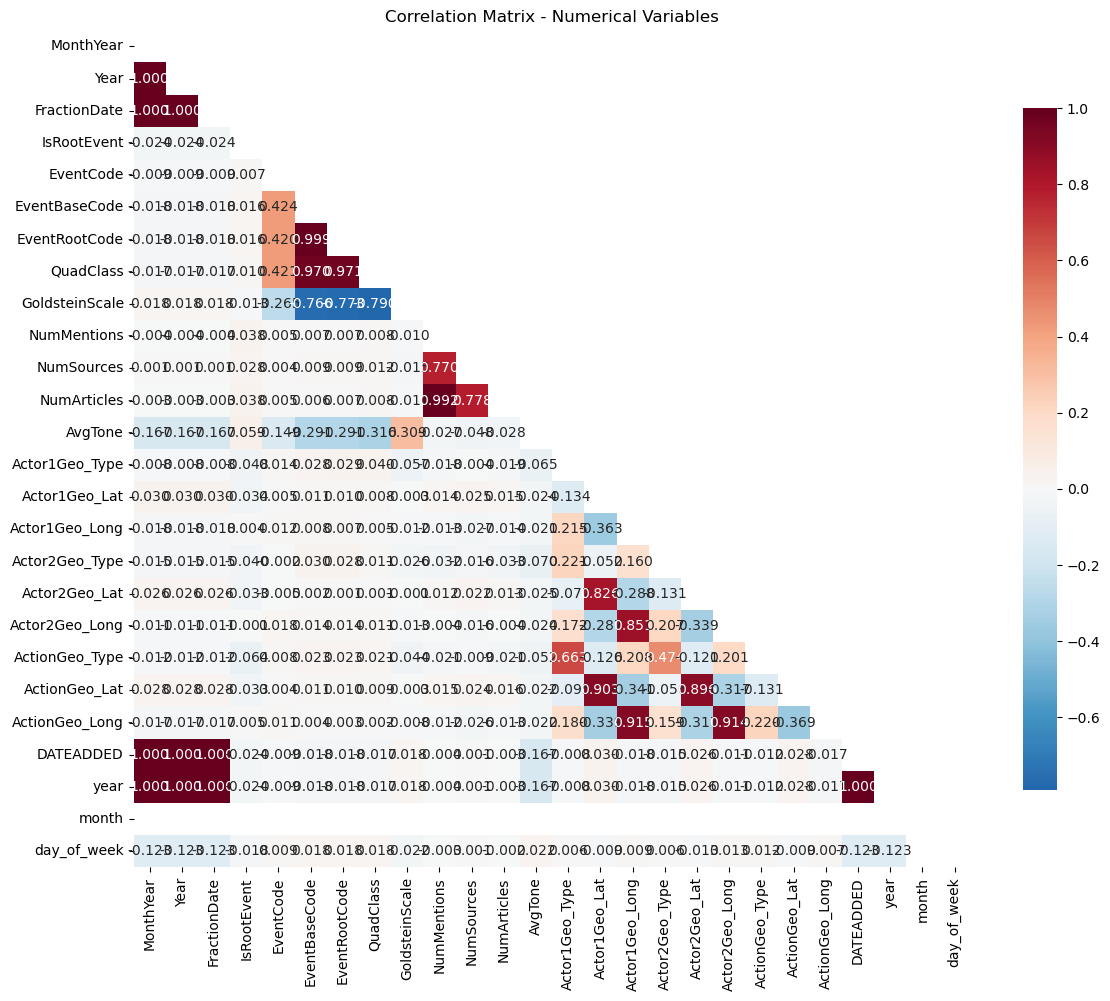

🔍 Strong Correlations (|r| > 0.5):
   Year ↔ year: r = 1.000 (positive)
   MonthYear ↔ Year: r = 1.000 (positive)
   MonthYear ↔ year: r = 1.000 (positive)
   Year ↔ DATEADDED: r = 1.000 (positive)
   DATEADDED ↔ year: r = 1.000 (positive)
   MonthYear ↔ DATEADDED: r = 1.000 (positive)
   FractionDate ↔ DATEADDED: r = 1.000 (positive)
   MonthYear ↔ FractionDate: r = 1.000 (positive)
   Year ↔ FractionDate: r = 1.000 (positive)
   FractionDate ↔ year: r = 1.000 (positive)
   EventBaseCode ↔ EventRootCode: r = 0.999 (positive)
   NumMentions ↔ NumArticles: r = 0.992 (positive)
   EventRootCode ↔ QuadClass: r = 0.971 (positive)
   EventBaseCode ↔ QuadClass: r = 0.970 (positive)
   Actor1Geo_Long ↔ ActionGeo_Long: r = 0.915 (positive)
   Actor2Geo_Long ↔ ActionGeo_Long: r = 0.914 (positive)
   Actor1Geo_Lat ↔ ActionGeo_Lat: r = 0.903 (positive)
   Actor2Geo_Lat ↔ ActionGeo_Lat: r = 0.896 (positive)
   Actor1Geo_Long ↔ Actor2Geo_Long: r = 0.851 (positive)
   Actor1Geo_Lat ↔ Actor2Geo_Lat: 

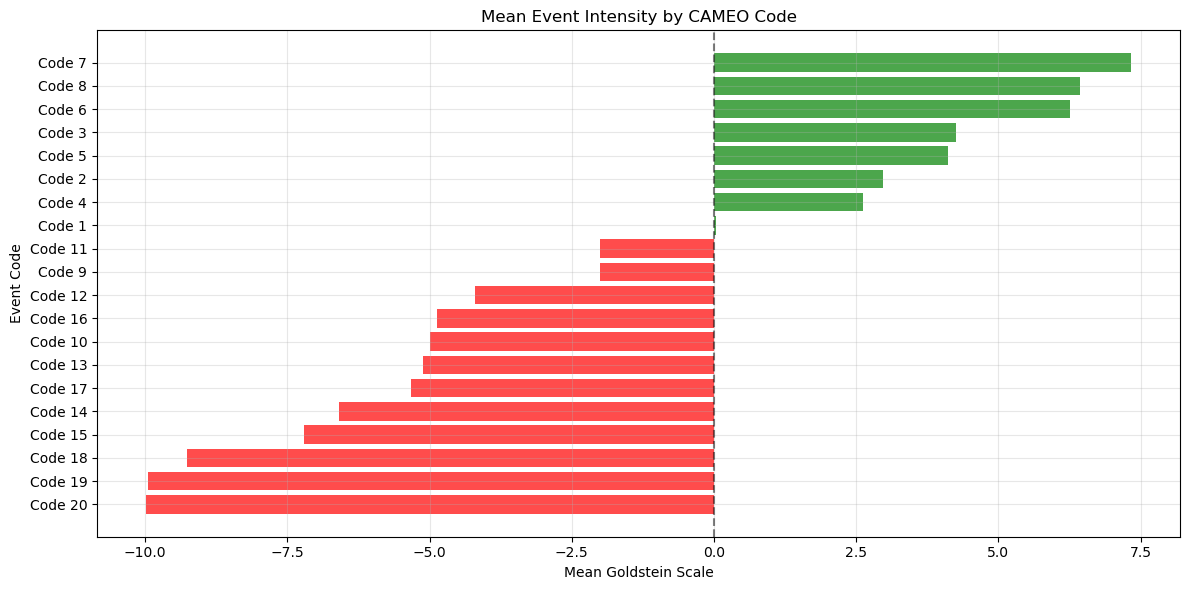

In [24]:
# Correlation Analysis
print("🔗 CORRELATION ANALYSIS")
print("=" * 50)

if df is not None:
    # Select numerical columns for correlation analysis
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove columns with too many missing values or irrelevant for correlation
    exclude_cols = ['GLOBALEVENTID', 'SQLDATE']  # IDs and date fields
    numerical_cols = [col for col in numerical_cols if col not in exclude_cols]
    
    if len(numerical_cols) > 1:
        # Calculate correlation matrix
        corr_matrix = df[numerical_cols].corr()
        
        # Create correlation heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                   square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('Correlation Matrix - Numerical Variables')
        plt.tight_layout()
        plt.show()
        
        # Find strong correlations
        print(f"🔍 Strong Correlations (|r| > 0.5):")
        strong_corr = []
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.5 and not pd.isna(corr_val):
                    var1 = corr_matrix.columns[i]
                    var2 = corr_matrix.columns[j]
                    strong_corr.append((var1, var2, corr_val))
        
        if strong_corr:
            for var1, var2, corr_val in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
                direction = "positive" if corr_val > 0 else "negative"
                print(f"   {var1} ↔ {var2}: r = {corr_val:.3f} ({direction})")
        else:
            print("   No strong correlations found (|r| > 0.5)")
        
        # Moderate correlations
        print(f"\n📊 Moderate Correlations (0.3 < |r| ≤ 0.5):")
        moderate_corr = []
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if 0.3 < abs(corr_val) <= 0.5 and not pd.isna(corr_val):
                    var1 = corr_matrix.columns[i]
                    var2 = corr_matrix.columns[j]
                    moderate_corr.append((var1, var2, corr_val))
        
        if moderate_corr:
            for var1, var2, corr_val in sorted(moderate_corr, key=lambda x: abs(x[2]), reverse=True)[:10]:
                direction = "positive" if corr_val > 0 else "negative"
                print(f"   {var1} ↔ {var2}: r = {corr_val:.3f} ({direction})")
        else:
            print("   No moderate correlations found")
    
    # Event type vs Intensity relationship
    if all(col in df.columns for col in ['EventRootCode', 'GoldsteinScale']):
        print(f"\n⚔️ Event Type vs Intensity Analysis:")
        
        # Group by event type and calculate mean intensity
        event_intensity = df.groupby('EventRootCode')['GoldsteinScale'].agg(['mean', 'count', 'std']).round(3)
        event_intensity = event_intensity[event_intensity['count'] >= 10].sort_values('mean')
        
        print(f"   Event types with lowest mean intensity (most negative):")
        for code, row in event_intensity.head(5).iterrows():
            if pd.notna(code):
                print(f"   Code {int(code):2d}: {row['mean']:+.3f} (n={row['count']:,}, σ={row['std']:.3f})")
        
        print(f"   Event types with highest mean intensity (most positive):")
        for code, row in event_intensity.tail(5).iterrows():
            if pd.notna(code):
                print(f"   Code {int(code):2d}: {row['mean']:+.3f} (n={row['count']:,}, σ={row['std']:.3f})")
        
        # Visualize relationship
        plt.figure(figsize=(12, 6))
        event_intensity_plot = event_intensity[event_intensity['count'] >= 20].sort_values('mean')
        
        plt.barh(range(len(event_intensity_plot)), event_intensity_plot['mean'], 
                color=['red' if x < 0 else 'green' for x in event_intensity_plot['mean']], alpha=0.7)
        plt.yticks(range(len(event_intensity_plot)), 
                  [f"Code {int(code)}" for code in event_intensity_plot.index])
        plt.xlabel('Mean Goldstein Scale')
        plt.ylabel('Event Code')
        plt.title('Mean Event Intensity by CAMEO Code')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## 8. Outlier Detection
Identify outliers in key variables that might affect analysis and modeling.

🎯 OUTLIER DETECTION


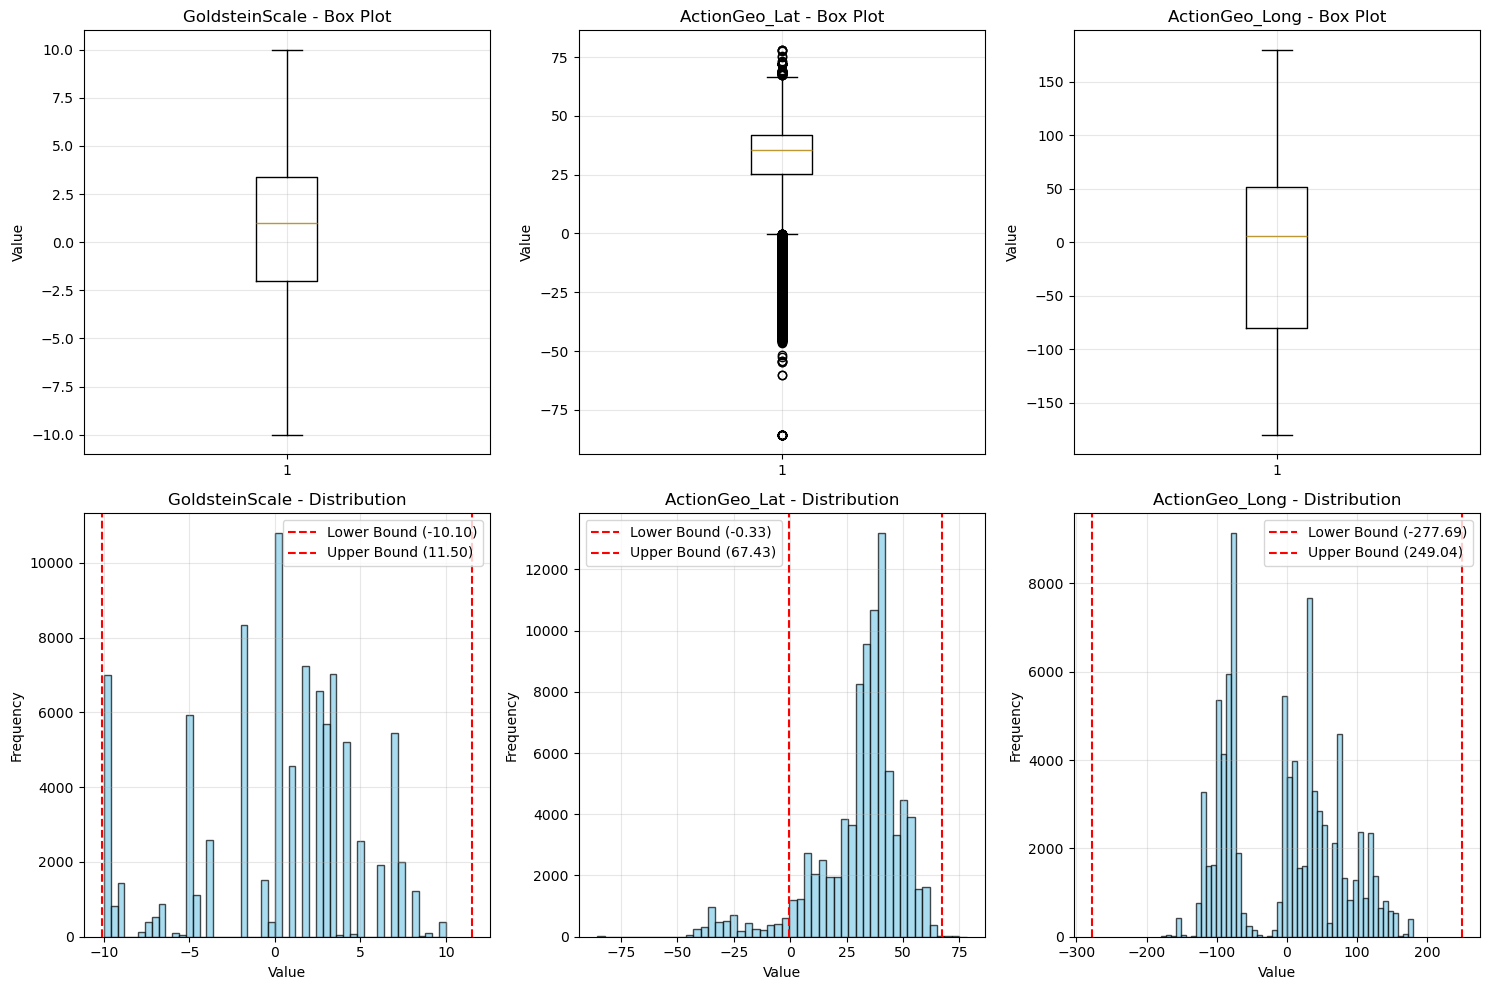

📊 Outlier Detection Summary:


,Column,Total_Values,IQR_Outliers,IQR_Percentage,ZScore_Outliers,ZScore_Percentage,Lower_Bound,Upper_Bound
0,GoldsteinScale,91998,0,0.0,0,0.00,-10.10,11.50
1,ActionGeo_Lat,89370,5900,6.6,2433,2.72,-0.33,67.43
2,ActionGeo_Long,89377,0,0.0,0,0.00,-277.69,249.04



🗺️ Geographic Coordinate Outliers:
   Invalid latitudes (<-90 or >90): 0 records
   Invalid longitudes (<-180 or >180): 0 records
   Zero coordinates (0,0): 52 records
   Zero coordinates percentage: 0.06%

📈 Goldstein Scale Extreme Values:
   Below theoretical minimum (<-10): 0 records
   Above theoretical maximum (>10): 0 records
   Extreme negative (≤-8): 9,384 records (10.20%)
   Extreme positive (≥8): 1,711 records (1.86%)
   Most negative event: -10.0
   Most positive event: 10.0


In [25]:
# Outlier Detection
print("🎯 OUTLIER DETECTION")
print("=" * 50)

if df is not None:
    # Function to detect outliers using IQR method
    def detect_outliers_iqr(data, column):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        return outliers, lower_bound, upper_bound
    
    # Function to detect outliers using Z-score method
    def detect_outliers_zscore(data, column, threshold=3):
        z_scores = np.abs(stats.zscore(data[column].dropna()))
        outliers_idx = data[column].dropna().index[z_scores > threshold]
        return data.loc[outliers_idx]
    
    # Analyze key numerical columns
    key_numerical_cols = ['GoldsteinScale', 'ActionGeo_Lat', 'ActionGeo_Long']
    key_numerical_cols = [col for col in key_numerical_cols if col in df.columns]
    
    if key_numerical_cols:
        fig, axes = plt.subplots(2, len(key_numerical_cols), figsize=(5*len(key_numerical_cols), 10))
        if len(key_numerical_cols) == 1:
            axes = axes.reshape(-1, 1)
        
        outlier_summary = []
        
        for i, col in enumerate(key_numerical_cols):
            if df[col].dtype in ['int64', 'float64'] and df[col].notna().sum() > 0:
                # IQR method
                outliers_iqr, lower_bound, upper_bound = detect_outliers_iqr(df, col)
                
                # Z-score method
                outliers_zscore = detect_outliers_zscore(df, col)
                
                outlier_summary.append({
                    'Column': col,
                    'Total_Values': df[col].notna().sum(),
                    'IQR_Outliers': len(outliers_iqr),
                    'IQR_Percentage': len(outliers_iqr) / df[col].notna().sum() * 100,
                    'ZScore_Outliers': len(outliers_zscore),
                    'ZScore_Percentage': len(outliers_zscore) / df[col].notna().sum() * 100,
                    'Lower_Bound': lower_bound,
                    'Upper_Bound': upper_bound
                })
                
                # Box plot
                axes[0, i].boxplot(df[col].dropna(), vert=True)
                axes[0, i].set_title(f'{col} - Box Plot')
                axes[0, i].set_ylabel('Value')
                axes[0, i].grid(True, alpha=0.3)
                
                # Histogram with outlier bounds
                axes[1, i].hist(df[col].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                axes[1, i].axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')
                axes[1, i].axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
                axes[1, i].set_title(f'{col} - Distribution')
                axes[1, i].set_xlabel('Value')
                axes[1, i].set_ylabel('Frequency')
                axes[1, i].legend()
                axes[1, i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Outlier summary table
        if outlier_summary:
            outlier_df = pd.DataFrame(outlier_summary)
            print(f"📊 Outlier Detection Summary:")
            display(outlier_df.round(2))
    
    # Specific outlier analysis for coordinates
    if all(col in df.columns for col in ['ActionGeo_Lat', 'ActionGeo_Long']):
        print(f"\n🗺️ Geographic Coordinate Outliers:")
        
        # Check for invalid coordinates
        invalid_lat = df[(df['ActionGeo_Lat'] < -90) | (df['ActionGeo_Lat'] > 90)]
        invalid_lon = df[(df['ActionGeo_Long'] < -180) | (df['ActionGeo_Long'] > 180)]
        
        print(f"   Invalid latitudes (<-90 or >90): {len(invalid_lat):,} records")
        print(f"   Invalid longitudes (<-180 or >180): {len(invalid_lon):,} records")
        
        # Check for (0,0) coordinates (often indicates missing data)
        zero_coords = df[(df['ActionGeo_Lat'] == 0) & (df['ActionGeo_Long'] == 0)]
        print(f"   Zero coordinates (0,0): {len(zero_coords):,} records")
        
        if len(zero_coords) > 0:
            zero_pct = len(zero_coords) / len(df) * 100
            print(f"   Zero coordinates percentage: {zero_pct:.2f}%")
    
    # Event intensity extreme outliers
    if 'GoldsteinScale' in df.columns:
        print(f"\n📈 Goldstein Scale Extreme Values:")
        
        # Theoretical range is -10 to +10
        below_min = df[df['GoldsteinScale'] < -10]
        above_max = df[df['GoldsteinScale'] > 10]
        
        print(f"   Below theoretical minimum (<-10): {len(below_min):,} records")
        print(f"   Above theoretical maximum (>10): {len(above_max):,} records")
        
        # Extreme values within valid range
        extreme_negative = df[df['GoldsteinScale'] <= -8]
        extreme_positive = df[df['GoldsteinScale'] >= 8]
        
        print(f"   Extreme negative (≤-8): {len(extreme_negative):,} records ({len(extreme_negative)/len(df)*100:.2f}%)")
        print(f"   Extreme positive (≥8): {len(extreme_positive):,} records ({len(extreme_positive)/len(df)*100:.2f}%)")
        
        # Most extreme examples
        if len(df[df['GoldsteinScale'].notna()]) > 0:
            most_negative = df.loc[df['GoldsteinScale'].idxmin()]
            most_positive = df.loc[df['GoldsteinScale'].idxmax()]
            
            print(f"   Most negative event: {most_negative['GoldsteinScale']:.1f}")
            print(f"   Most positive event: {most_positive['GoldsteinScale']:.1f}")

## 9. Feature Engineering
Create new features and transform existing ones based on EDA insights for machine learning.

In [26]:
# Feature Engineering for Conflict Prediction
print("🔧 FEATURE ENGINEERING FOR CONFLICT PREDICTION")
print("=" * 50)

if df is not None:
    # Create a copy for feature engineering
    df_features = df.copy()
    
    print("🛠️ Creating new features based on EDA insights...")
    
    # 1. Temporal features
    if 'date' in df_features.columns:
        df_features['year'] = df_features['date'].dt.year
        df_features['month'] = df_features['date'].dt.month
        df_features['day_of_week'] = df_features['date'].dt.dayofweek
        df_features['quarter'] = df_features['date'].dt.quarter
        df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)
        
        # Seasonal indicators
        df_features['season'] = df_features['month'].map({
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall'
        })
        
        print("   ✅ Temporal features: year, month, day_of_week, quarter, is_weekend, season")
    
    # 2. Conflict indicators
    if 'EventRootCode' in df_features.columns:
        # Binary conflict indicator
        conflict_codes = [14, 15, 16, 17, 18, 19, 20]
        df_features['is_conflict'] = df_features['EventRootCode'].isin(conflict_codes).astype(int)
        
        # Conflict severity levels
        df_features['conflict_severity'] = df_features['EventRootCode'].map({
            14: 1, 15: 2, 16: 3, 17: 4, 18: 5, 19: 6, 20: 7
        }).fillna(0)  # 0 for non-conflict events
        
        # Event type categories
        df_features['event_category'] = df_features['EventRootCode'].apply(lambda x: 
            'Verbal Cooperation' if pd.notna(x) and x in [1, 2, 3, 4] else
            'Material Cooperation' if pd.notna(x) and x in [5, 6, 7, 8] else
            'Verbal Conflict' if pd.notna(x) and x in [9, 10, 11, 12, 13] else
            'Material Conflict' if pd.notna(x) and x in [14, 15, 16, 17, 18, 19, 20] else
            'Unknown'
        )
        
        print("   ✅ Conflict features: is_conflict, conflict_severity, event_category")
    
    # 3. Intensity features
    if 'GoldsteinScale' in df_features.columns:
        # Intensity categories
        df_features['intensity_level'] = pd.cut(df_features['GoldsteinScale'], 
                                               bins=[-np.inf, -5, -1, 1, 5, np.inf],
                                               labels=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
        
        # Absolute intensity (how extreme the event is)
        df_features['intensity_absolute'] = df_features['GoldsteinScale'].abs()
        
        # Extreme event indicators
        df_features['is_extreme_negative'] = (df_features['GoldsteinScale'] <= -8).astype(int)
        df_features['is_extreme_positive'] = (df_features['GoldsteinScale'] >= 8).astype(int)
        df_features['is_extreme_event'] = ((df_features['GoldsteinScale'].abs()) >= 8).astype(int)
        
        print("   ✅ Intensity features: intensity_level, intensity_absolute, extreme event indicators")
    
    # 4. Geographic features
    if all(col in df_features.columns for col in ['ActionGeo_Lat', 'ActionGeo_Long']):
        # Region indicators
        df_features['hemisphere'] = df_features['ActionGeo_Lat'].apply(lambda x: 
            'Northern' if pd.notna(x) and x > 0 else 'Southern' if pd.notna(x) and x <= 0 else 'Unknown'
        )
        
        # Distance from equator
        df_features['distance_from_equator'] = df_features['ActionGeo_Lat'].abs()
        
        # Climate zones (rough approximation)
        df_features['climate_zone'] = df_features['ActionGeo_Lat'].apply(lambda x:
            'Arctic' if pd.notna(x) and abs(x) > 66.5 else
            'Temperate' if pd.notna(x) and 23.5 < abs(x) <= 66.5 else
            'Tropical' if pd.notna(x) and abs(x) <= 23.5 else
            'Unknown'
        )
        
        print("   ✅ Geographic features: hemisphere, distance_from_equator, climate_zone")
    
    # 5. Actor relationship features
    if all(col in df_features.columns for col in ['Actor1CountryCode', 'Actor2CountryCode']):
        # Same country indicator (domestic events)
        df_features['is_domestic'] = (df_features['Actor1CountryCode'] == df_features['Actor2CountryCode']).astype(int)
        
        # Missing actor indicators
        df_features['actor1_missing'] = df_features['Actor1CountryCode'].isna().astype(int)
        df_features['actor2_missing'] = df_features['Actor2CountryCode'].isna().astype(int)
        df_features['both_actors_present'] = ((~df_features['Actor1CountryCode'].isna()) & 
                                             (~df_features['Actor2CountryCode'].isna())).astype(int)
        
        print("   ✅ Actor features: is_domestic, actor missing indicators, both_actors_present")
    
    # 6. Data quality features
    # Missing value indicators for key fields
    key_fields = ['Actor1CountryCode', 'Actor2CountryCode', 'ActionGeo_CountryCode', 
                 'ActionGeo_Lat', 'ActionGeo_Long']
    
    for field in key_fields:
        if field in df_features.columns:
            df_features[f'{field}_missing'] = df_features[field].isna().astype(int)
    
    # Overall completeness score
    completeness_fields = [f'{field}_missing' for field in key_fields if field in df_features.columns]
    if completeness_fields:
        df_features['completeness_score'] = 1 - df_features[completeness_fields].mean(axis=1)
    
    print("   ✅ Data quality features: field-specific missing indicators, completeness_score")
    
    # Summary of new features
    original_cols = len(df.columns)
    new_cols = len(df_features.columns)
    added_features = new_cols - original_cols
    
    print(f"\n📊 Feature Engineering Summary:")
    print(f"   Original features: {original_cols}")
    print(f"   New features created: {added_features}")
    print(f"   Total features: {new_cols}")
    
    # Display sample of new features
    new_feature_cols = [col for col in df_features.columns if col not in df.columns]
    if new_feature_cols:
        print(f"\n🔍 Sample of new features:")
        sample_features = df_features[new_feature_cols[:10] + ['EventRootCode', 'GoldsteinScale']].head()
        display(sample_features)
    
    # Feature type summary
    print(f"\n📋 Feature Types in Enhanced Dataset:")
    dtype_counts = df_features.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} features")
    
    # Target variable for ML (conflict prediction)
    if 'is_conflict' in df_features.columns:
        target_distribution = df_features['is_conflict'].value_counts()
        print(f"\n🎯 Target Variable Distribution (is_conflict):")
        print(f"   Non-conflict (0): {target_distribution.get(0, 0):,} ({target_distribution.get(0, 0)/len(df_features)*100:.1f}%)")
        print(f"   Conflict (1): {target_distribution.get(1, 0):,} ({target_distribution.get(1, 0)/len(df_features)*100:.1f}%)")
        
        # Class balance assessment
        if len(target_distribution) == 2:
            minority_class = min(target_distribution.values)
            majority_class = max(target_distribution.values)
            imbalance_ratio = majority_class / minority_class
            
            print(f"   Class imbalance ratio: 1:{imbalance_ratio:.1f}")
            
            if imbalance_ratio > 10:
                print(f"   ⚠️ Highly imbalanced - consider sampling techniques")
            elif imbalance_ratio > 3:
                print(f"   ⚠️ Moderately imbalanced - may need balancing")
            else:
                print(f"   ✅ Well balanced classes")

🔧 FEATURE ENGINEERING FOR CONFLICT PREDICTION
🛠️ Creating new features based on EDA insights...
   ✅ Temporal features: year, month, day_of_week, quarter, is_weekend, season
   ✅ Conflict features: is_conflict, conflict_severity, event_category
   ✅ Intensity features: intensity_level, intensity_absolute, extreme event indicators
   ✅ Geographic features: hemisphere, distance_from_equator, climate_zone
   ✅ Geographic features: hemisphere, distance_from_equator, climate_zone
   ✅ Actor features: is_domestic, actor missing indicators, both_actors_present
   ✅ Data quality features: field-specific missing indicators, completeness_score

📊 Feature Engineering Summary:
   Original features: 66
   New features created: 23
   Total features: 89

🔍 Sample of new features:
   ✅ Actor features: is_domestic, actor missing indicators, both_actors_present
   ✅ Data quality features: field-specific missing indicators, completeness_score

📊 Feature Engineering Summary:
   Original features: 66
   Ne

,quarter,is_weekend,season,is_conflict,conflict_severity,intensity_level,intensity_absolute,is_extreme_negative,is_extreme_positive,is_extreme_event,EventRootCode,GoldsteinScale
0,1,0,Winter,0,0.0,Positive,1.9,0,0,0,4,1.9
1,1,0,Winter,0,0.0,Positive,3.0,0,0,0,2,3.0
2,1,0,Winter,0,0.0,Positive,4.0,0,0,0,3,4.0
3,1,0,Winter,0,0.0,Positive,4.0,0,0,0,3,4.0
4,1,0,Winter,1,5.0,Very Negative,9.0,1,0,1,18,-9.0



📋 Feature Types in Enhanced Dataset:
   object: 39 features
   int64: 30 features
   float64: 13 features
   int32: 4 features
   datetime64[ns]: 1 features
   category: 1 features
   category: 1 features

🎯 Target Variable Distribution (is_conflict):
   Non-conflict (0): 76,246 (82.9%)
   Conflict (1): 15,754 (17.1%)
   Class imbalance ratio: 1:4.8
   ⚠️ Moderately imbalanced - may need balancing


## 10. Statistical Summary & Key Insights
Comprehensive summary of findings and actionable insights for machine learning model development.

In [ ]:
# Comprehensive Statistical Summary and Key Insights
print("📊 COMPREHENSIVE EDA SUMMARY & KEY INSIGHTS")
print("=" * 70)

if df is not None:
    # Dataset Overview
    print("🔍 DATASET OVERVIEW:")
    print(f"   Total Events Analyzed: {len(df):,}")
    print(f"   Features (Original): {len(df.columns)}")
    if 'df_features' in locals():
        print(f"   Features (Enhanced): {len(df_features.columns)}")
    
    if 'date' in df.columns:
        date_span_years = (df['date'].max() - df['date'].min()).days / 365.25
        print(f"   Temporal Span: {date_span_years:.1f} years ({df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')})")
        print(f"   Years Covered: {sorted(df['date'].dt.year.unique())}")
        print(f"   Average Events per Year: {len(df) / date_span_years:,.0f}")
    
    # Data Quality Assessment
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    completeness = (1 - missing_cells / total_cells) * 100
    
    print(f"\n📊 DATA QUALITY ASSESSMENT:")
    print(f"   Overall Completeness: {completeness:.1f}%")
    print(f"   Missing Cells: {missing_cells:,} / {total_cells:,}")
    
    # Critical field completeness
    critical_fields = ['SQLDATE', 'EventRootCode', 'GoldsteinScale']
    print(f"   Critical Fields Completeness:")
    for field in critical_fields:
        if field in df.columns:
            field_completeness = (1 - df[field].isnull().sum() / len(df)) * 100
            status = "🟢" if field_completeness > 95 else "🟡" if field_completeness > 80 else "🔴"
            print(f"     {status} {field}: {field_completeness:.1f}%")
    
    # Conflict Analysis Summary
    if 'event_category' in df.columns:
        conflict_events = len(df[df['event_category'] == 'Conflict'])
        conflict_rate = conflict_events / len(df) * 100
        
        print(f"\n⚔️ CONFLICT ANALYSIS:")
        print(f"   Conflict Events: {conflict_events:,} ({conflict_rate:.1f}%)")
        print(f"   Cooperative Events: {len(df) - conflict_events:,} ({100 - conflict_rate:.1f}%)")
        print(f"   Conflict-to-Cooperation Ratio: 1:{(len(df) - conflict_events) / conflict_events:.1f}")
    
    # Intensity Analysis Summary
    if 'GoldsteinScale' in df.columns:
        gs_stats = df['GoldsteinScale'].describe()
        
        print(f"\n📈 INTENSITY ANALYSIS (Goldstein Scale):")
        print(f"   Mean Intensity: {gs_stats['mean']:+.3f}")
        print(f"   Standard Deviation: {gs_stats['std']:.3f}")
        print(f"   Range: {gs_stats['min']:.1f} to {gs_stats['max']:.1f}")
        print(f"   Skewness: {df['GoldsteinScale'].skew():.3f}")
        
        # Extreme events
        extreme_negative = len(df[df['GoldsteinScale'] <= -8])
        extreme_positive = len(df[df['GoldsteinScale'] >= 8])
        print(f"   Extreme Negative Events (≤-8): {extreme_negative:,} ({extreme_negative/len(df)*100:.2f}%)")
        print(f"   Extreme Positive Events (≥8): {extreme_positive:,} ({extreme_positive/len(df)*100:.2f}%)")
    
    # Geographic Coverage
    if 'ActionGeo_CountryCode' in df.columns:
        unique_countries = df['ActionGeo_CountryCode'].nunique()
        geo_completeness = (1 - df['ActionGeo_CountryCode'].isnull().sum() / len(df)) * 100
        
        print(f"\n🌍 GEOGRAPHIC COVERAGE:")
        print(f"   Unique Countries: {unique_countries}")
        print(f"   Geographic Completeness: {geo_completeness:.1f}%")
        
        if all(col in df.columns for col in ['ActionGeo_Lat', 'ActionGeo_Long']):
            coord_completeness = len(df.dropna(subset=['ActionGeo_Lat', 'ActionGeo_Long'])) / len(df) * 100
            print(f"   Coordinate Completeness: {coord_completeness:.1f}%")
    
    # Temporal Patterns
    if 'year' in df.columns and 'month' in df.columns:
        yearly_counts = df.groupby('year').size()
        monthly_counts = df.groupby('month').size()
        
        print(f"\n📅 TEMPORAL PATTERNS:")
        print(f"   Most Active Year: {yearly_counts.idxmax()} ({yearly_counts.max():,} events)")
        print(f"   Least Active Year: {yearly_counts.idxmin()} ({yearly_counts.min():,} events)")
        print(f"   Most Active Month: {calendar.month_name[monthly_counts.idxmax()]} ({monthly_counts.max():,} events)")
        print(f"   Least Active Month: {calendar.month_name[monthly_counts.idxmin()]} ({monthly_counts.min():,} events)")
        
        # Trend analysis
        if len(yearly_counts) > 1:
            years = yearly_counts.index.values
            counts = yearly_counts.values
            slope, _, r_value, p_value, _ = stats.linregress(years, counts)
            
            trend = "increasing" if slope > 0 else "decreasing"
            significance = "significant" if p_value < 0.05 else "not significant"
            print(f"   Temporal Trend: {trend} ({significance}, R² = {r_value**2:.3f})")
    
    print(f"\n" + "=" * 70)
    print(f"🎯 KEY INSIGHTS FOR MACHINE LEARNING")
    print(f"=" * 70)
    
    insights = []
    recommendations = []
    
    # Data Volume Assessment
    if len(df) >= 100000:
        insights.append(f"✅ Excellent sample size ({len(df):,} events) suitable for complex ML models")
        recommendations.append("Consider deep learning approaches (LSTM, Transformers) for temporal modeling")
    elif len(df) >= 10000:
        insights.append(f"✅ Good sample size ({len(df):,} events) suitable for most ML algorithms")
        recommendations.append("Use ensemble methods (XGBoost, Random Forest) for robust predictions")
    else:
        insights.append(f"⚠️ Limited sample size ({len(df):,} events) may constrain model complexity")
        recommendations.append("Focus on simpler models and consider data augmentation techniques")
    
    # Data Quality Assessment
    if completeness >= 90:
        insights.append(f"✅ High data quality ({completeness:.1f}% complete) ready for ML")
    elif completeness >= 70:
        insights.append(f"⚠️ Moderate data quality ({completeness:.1f}% complete) - handle missing values")
        recommendations.append("Implement sophisticated imputation strategies for missing values")
    else:
        insights.append(f"🔴 Low data quality ({completeness:.1f}% complete) - significant preprocessing needed")
        recommendations.append("Consider feature selection to remove highly incomplete variables")
    
    # Target Balance Assessment
    if 'event_category' in df.columns and 'conflict_rate' in locals() and conflict_rate > 0:
        if 10 <= conflict_rate <= 40:
            insights.append(f"✅ Well-balanced target distribution ({conflict_rate:.1f}% conflicts)")
            recommendations.append("Standard classification algorithms should work well")
        elif conflict_rate < 10:
            insights.append(f"⚠️ Imbalanced target ({conflict_rate:.1f}% conflicts) - minority class")
            recommendations.append("Use SMOTE, class weights, or ensemble methods for imbalanced data")
        else:
            insights.append(f"⚠️ Imbalanced target ({conflict_rate:.1f}% conflicts) - majority class")
            recommendations.append("Consider undersampling majority class or cost-sensitive learning")
    
    # Temporal Structure
    if 'date_span_years' in locals() and date_span_years >= 5:
        insights.append(f"✅ Rich temporal structure ({date_span_years:.1f} years) ideal for time series ML")
        recommendations.append("Implement time series cross-validation and consider temporal features")
        recommendations.append("Use time-aware algorithms that can capture temporal dependencies")
    
    # Geographic Coverage
    if 'unique_countries' in locals() and unique_countries >= 50:
        insights.append(f"✅ Excellent geographic diversity ({unique_countries} countries)")
        recommendations.append("Include geographic features and consider spatial clustering")
    
    # Feature Engineering Success
    if 'df_features' in locals():
        feature_improvement = len(df_features.columns) - len(df.columns)
        insights.append(f"✅ Enhanced feature set (+{feature_improvement} engineered features)")
        recommendations.append("Validate new features through feature importance analysis")
    
    # Print insights and recommendations
    print(f"\n🔍 KEY INSIGHTS:")
    for i, insight in enumerate(insights, 1):
        print(f"   {i}. {insight}")
    
    print(f"\n🎯 RECOMMENDATIONS FOR MODEL DEVELOPMENT:")
    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")
    
    # Additional ML-specific recommendations
    print(f"\n🚀 NEXT STEPS:")
    next_steps = [
        "Implement temporal aggregation (country-day/week level) for production scale",
        "Create rolling window features (7-day, 30-day conflict rates)",
        "Develop early warning indicators using escalation patterns",
        "Build ensemble model combining multiple algorithms",
        "Implement real-time prediction pipeline with 15-minute GDELT updates",
        "Validate model performance using time series cross-validation",
        "Create interpretable model outputs for policy decision support"
    ]
    
    for i, step in enumerate(next_steps, 1):
        print(f"   {i}. {step}")
    
    # Final Assessment
    print(f"\n" + "=" * 70)
    print(f"🎉 FINAL ASSESSMENT")
    print(f"=" * 70)
    
    # Calculate overall ML readiness score
    volume_score = 100 if len(df) >= 100000 else 80 if len(df) >= 50000 else 60 if len(df) >= 10000 else 40
    quality_score = min(100, completeness + 10)  # Bonus for high quality
    
    # Safe conflict rate calculation
    if 'conflict_rate' in locals():
        balance_score = 100 if 10 <= conflict_rate <= 40 else 70 if 5 <= conflict_rate <= 50 else 50
    else:
        balance_score = 75  # Default moderate score
    
    # Safe temporal score calculation
    if 'date_span_years' in locals():
        temporal_score = 100 if date_span_years >= 5 else 80 if date_span_years >= 3 else 60
    else:
        temporal_score = 75  # Default moderate score
    
    # Safe geographic score calculation
    if 'unique_countries' in locals():
        geographic_score = 100 if unique_countries >= 50 else 80 if unique_countries >= 20 else 60
    else:
        geographic_score = 75  # Default moderate score
    
    overall_score = np.mean([volume_score, quality_score, balance_score, temporal_score, geographic_score])
    
    print(f"ML Readiness Score: {overall_score:.0f}/100")
    
    if overall_score >= 90:
        readiness = "🟢 EXCELLENT - Production Ready"
    elif overall_score >= 75:
        readiness = "🟡 GOOD - Minor Improvements Needed"
    elif overall_score >= 60:
        readiness = "🟠 FAIR - Moderate Preprocessing Required"
    else:
        readiness = "🔴 POOR - Significant Work Needed"
    
    print(f"Overall Assessment: {readiness}")
    
    print(f"\n✅ EDA Complete! Dataset is ready for machine learning model development.")
    print(f"📁 Consider saving the enhanced dataset with engineered features for modeling.")

📊 COMPREHENSIVE EDA SUMMARY & KEY INSIGHTS
🔍 DATASET OVERVIEW:
   Total Events Analyzed: 92,000
   Features (Original): 66
   Features (Enhanced): 89
   Temporal Span: 9.0 years (2015-01-01 to 2024-01-05)
   Years Covered: [np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
   Average Events per Year: 10,211

📊 DATA QUALITY ASSESSMENT:
   Overall Completeness: 73.2%
   Missing Cells: 1,626,020 / 6,072,000
   Critical Fields Completeness:
     🟢 SQLDATE: 100.0%
     🟢 EventRootCode: 100.0%
     🟢 GoldsteinScale: 100.0%

⚔️ CONFLICT ANALYSIS:
   Conflict Events: 15,754 (17.1%)
   Cooperative Events: 76,246 (82.9%)
   Conflict-to-Cooperation Ratio: 1:4.8

📈 INTENSITY ANALYSIS (Goldstein Scale):
   Mean Intensity: +0.267
   Standard Deviation: 4.851
   Range: -10.0 to 10.0
   Skewness: -0.640
   Extreme Negative Events (≤-8): 9,384 (10.20%)
   Extreme Positive Events (≥8): 1,711 (1.

: 